In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path
import cv2
from tqdm import tqdm

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet

In [5]:
size = 512

In [6]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')
#fnames = get_image_files(path, recurse=True)

images, lbl_bbox = get_annotations(path/'WhiteBloodCellCoco.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [7]:
#train_regex = re.compile(r'(fold_0|fold_1|fold_2)')
val_regex = re.compile(r'(fold_3)')
def split_func(fn):
    return val_regex.search(str(fn)) is not None

In [8]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      max_lighting=0.15,
                      max_zoom=1.2,
                      max_warp=0.2,
                      p_affine=0.75,
                      p_lighting=0.75,
                      #xtra_tfms=xtra_tfms,
                     )

In [9]:
data = (ObjectItemList.from_folder(path, recurse=True)#, extensions='.bmp'
        #Where are the images? -> in coco
        .split_by_valid_func(split_func)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)#, label_cls=BloodCellObjectCategoryList
        #How to find the labels? -> use get_y_func
        .transform(tfms, tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=32, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate

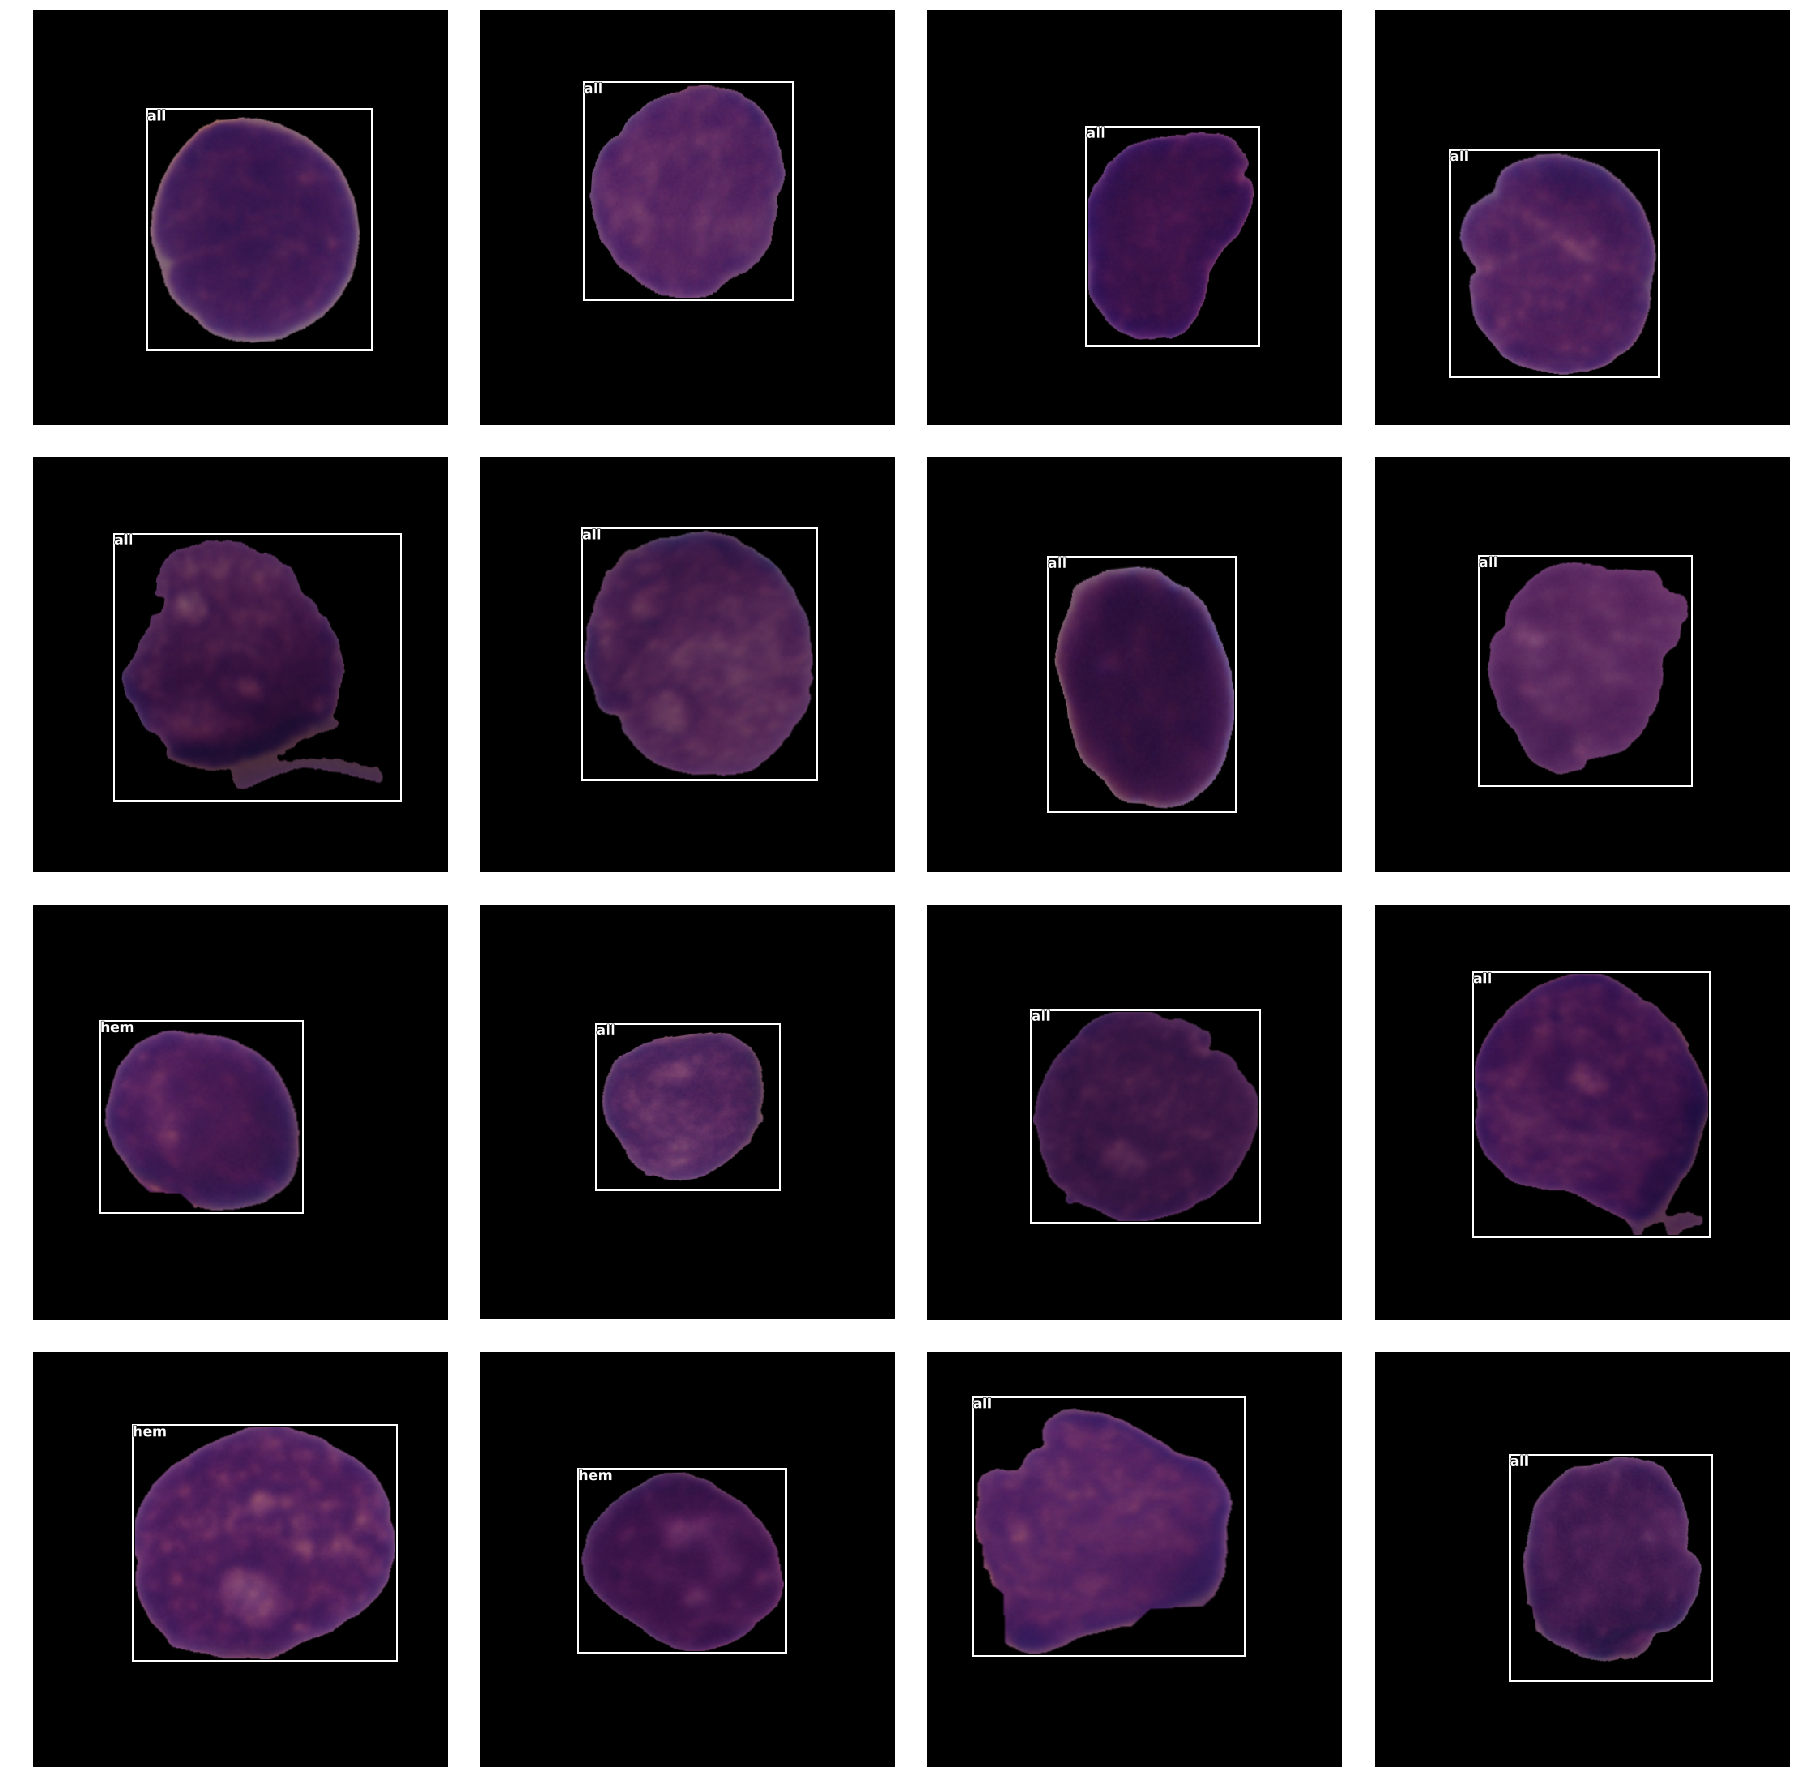

In [10]:
data.show_batch(rows=4, ds_type=DatasetType.Train, figsize=(25,25))

In [11]:
# Sehr gut nicht verändern
create_anchors(sizes=[(16,16)], ratios=[0.5, 1, 2], scales=[1, 1.5, 2])

tensor([[-0.9375, -0.9375,  0.3536,  0.7071],
        [-0.9375, -0.9375,  0.5303,  1.0607],
        [-0.9375, -0.9375,  0.7071,  1.4142],
        ...,
        [ 0.9375,  0.9375,  0.7071,  0.3536],
        [ 0.9375,  0.9375,  1.0607,  0.5303],
        [ 0.9375,  0.9375,  1.4142,  0.7071]])

In [12]:
anchors_8 = create_anchors(sizes=[(8, 8)], ratios=[0.5, 1, 2], scales=[0.75, 1, 2])

In [13]:
anchors_4 = create_anchors(sizes=[(4,4)], ratios=[1], scales=[0.35, 0.5, 0.6])

In [14]:
anchors = create_anchors(sizes=[(16,16), (8, 8), (4,4)], ratios=[0.5, 1, 2], scales=[0.15, 0.25, 0.5, 0.75, 1, 1.5, 2])
print(len(anchors))
anchors[:20]

7056


tensor([[-0.9375, -0.9375,  0.0530,  0.1061],
        [-0.9375, -0.9375,  0.0884,  0.1768],
        [-0.9375, -0.9375,  0.1768,  0.3536],
        [-0.9375, -0.9375,  0.2652,  0.5303],
        [-0.9375, -0.9375,  0.3536,  0.7071],
        [-0.9375, -0.9375,  0.5303,  1.0607],
        [-0.9375, -0.9375,  0.7071,  1.4142],
        [-0.9375, -0.9375,  0.0750,  0.0750],
        [-0.9375, -0.9375,  0.1250,  0.1250],
        [-0.9375, -0.9375,  0.2500,  0.2500],
        [-0.9375, -0.9375,  0.3750,  0.3750],
        [-0.9375, -0.9375,  0.5000,  0.5000],
        [-0.9375, -0.9375,  0.7500,  0.7500],
        [-0.9375, -0.9375,  1.0000,  1.0000],
        [-0.9375, -0.9375,  0.1061,  0.0530],
        [-0.9375, -0.9375,  0.1768,  0.0884],
        [-0.9375, -0.9375,  0.3536,  0.1768],
        [-0.9375, -0.9375,  0.5303,  0.2652],
        [-0.9375, -0.9375,  0.7071,  0.3536],
        [-0.9375, -0.9375,  1.0607,  0.5303]])

/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


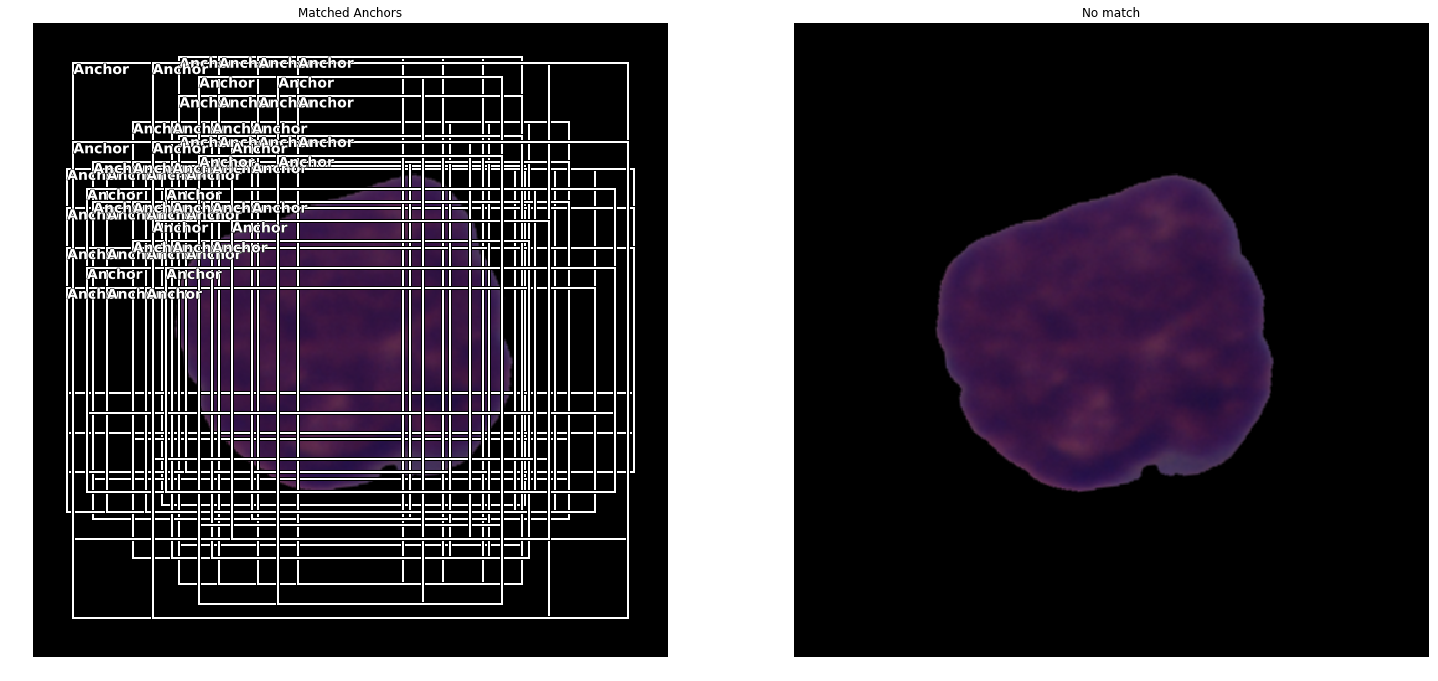

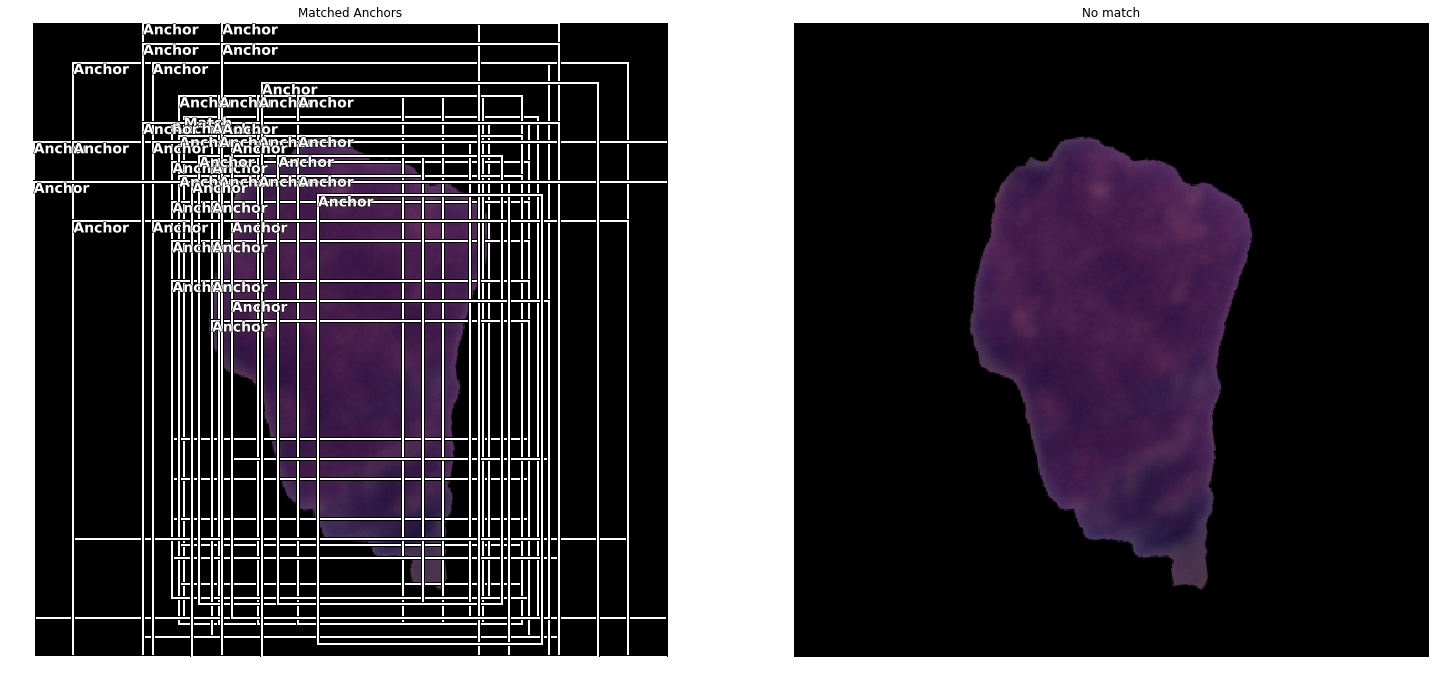

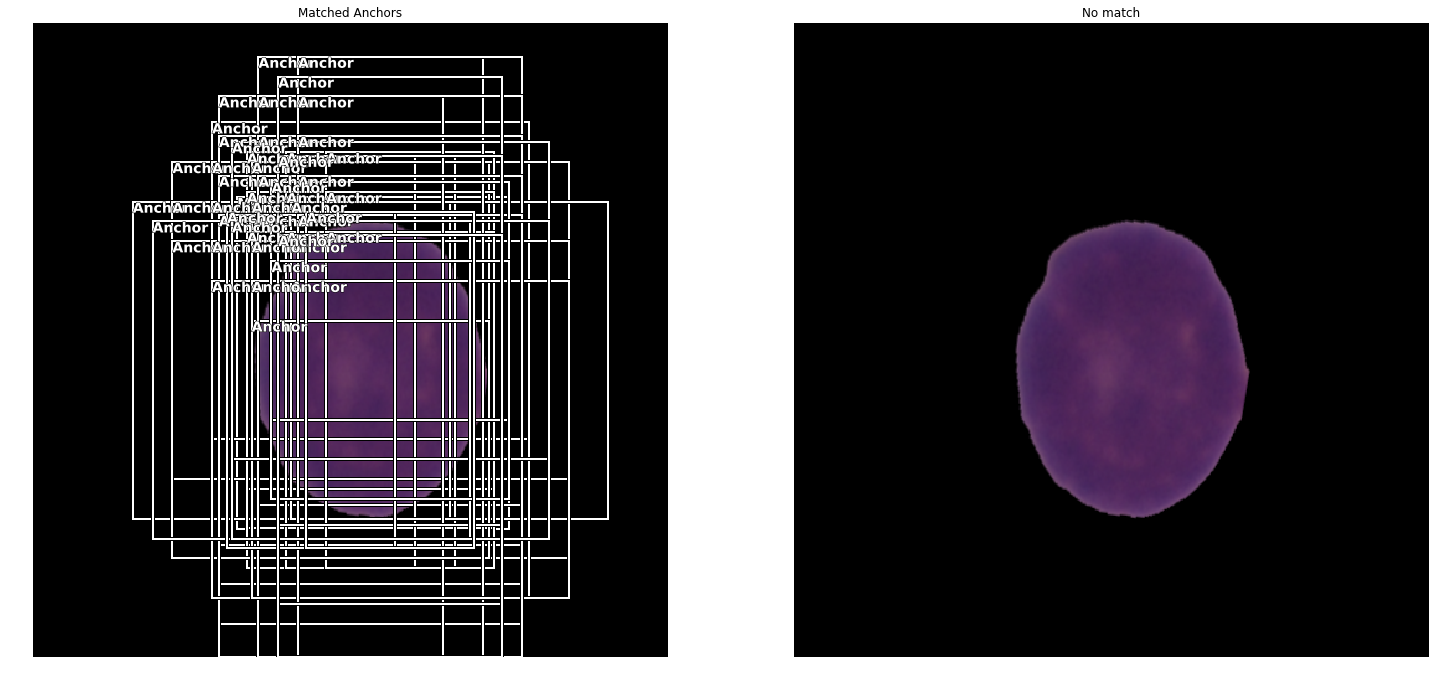

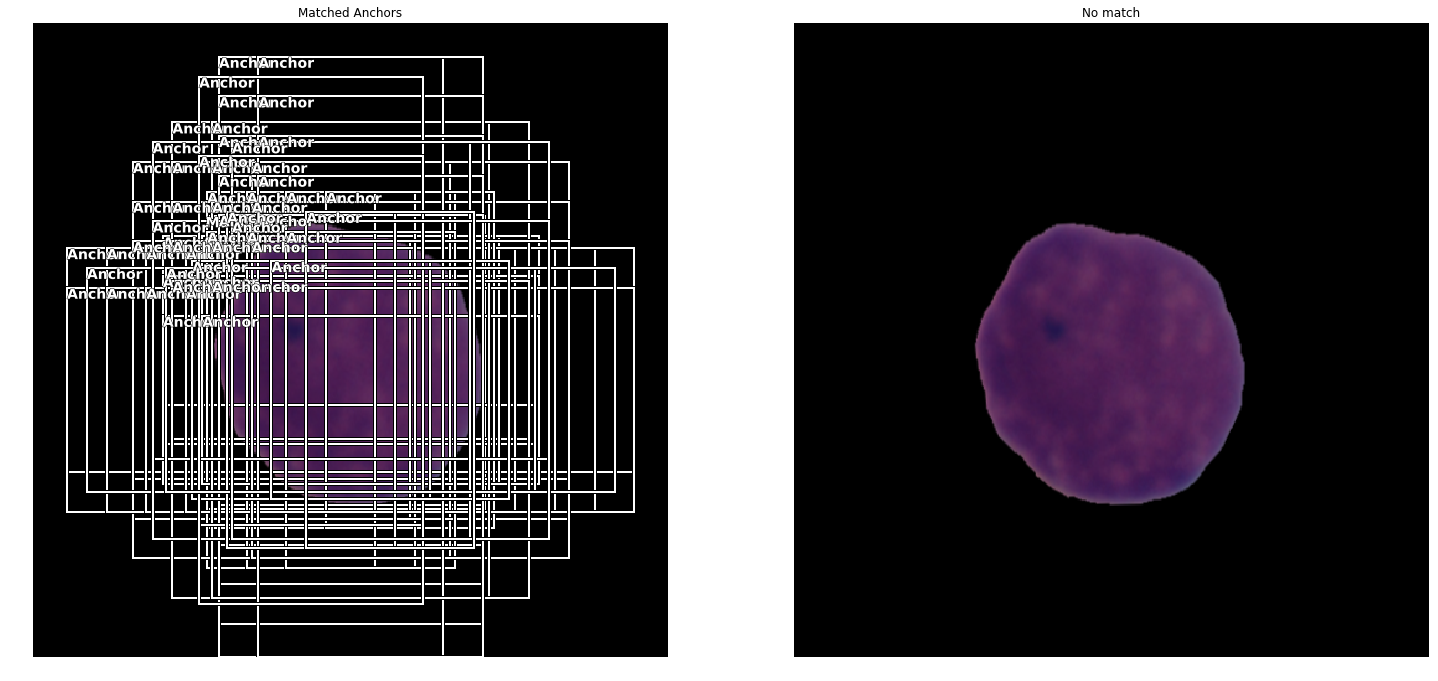

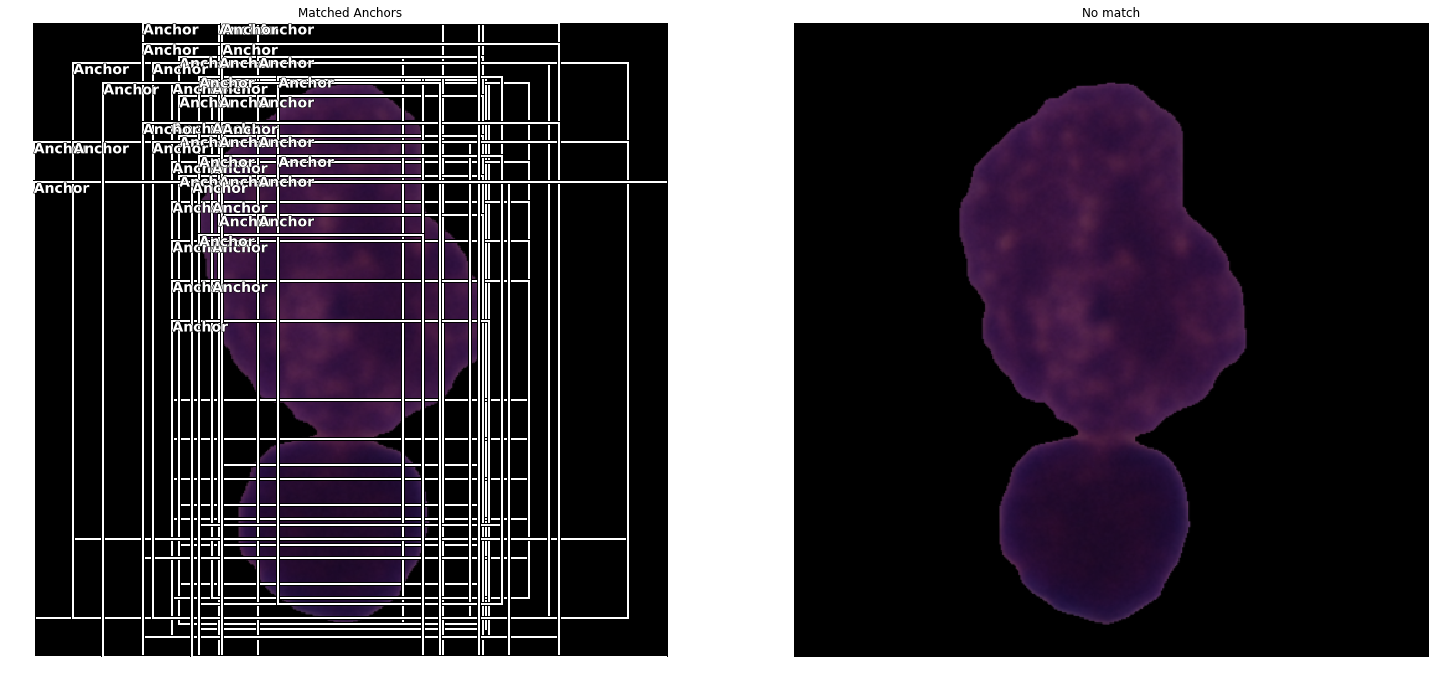

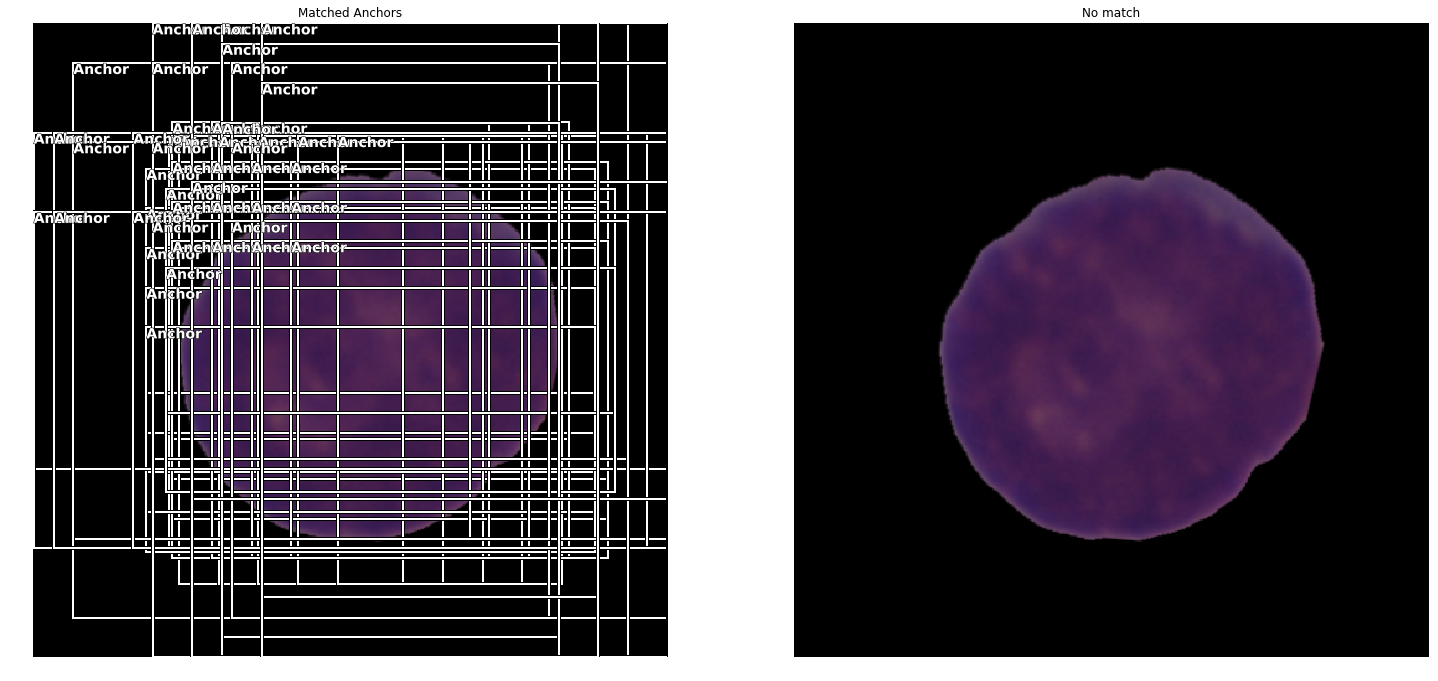

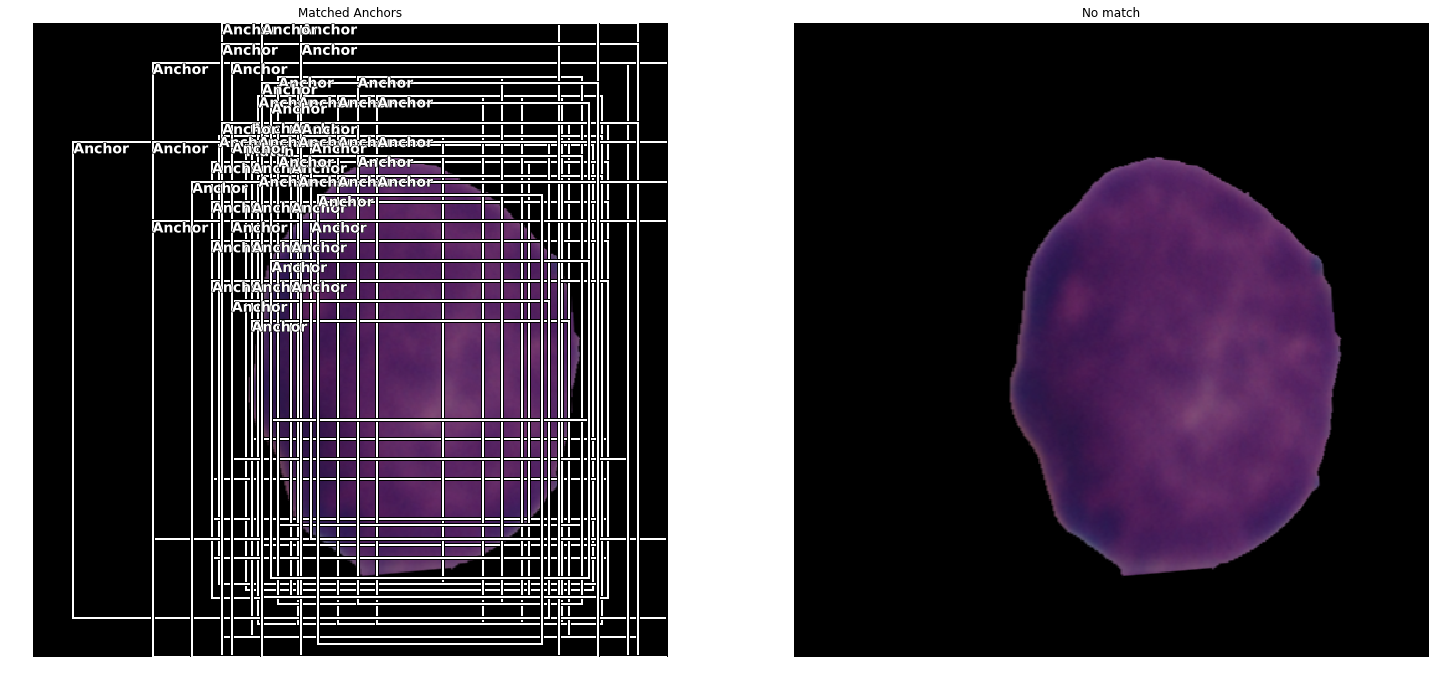

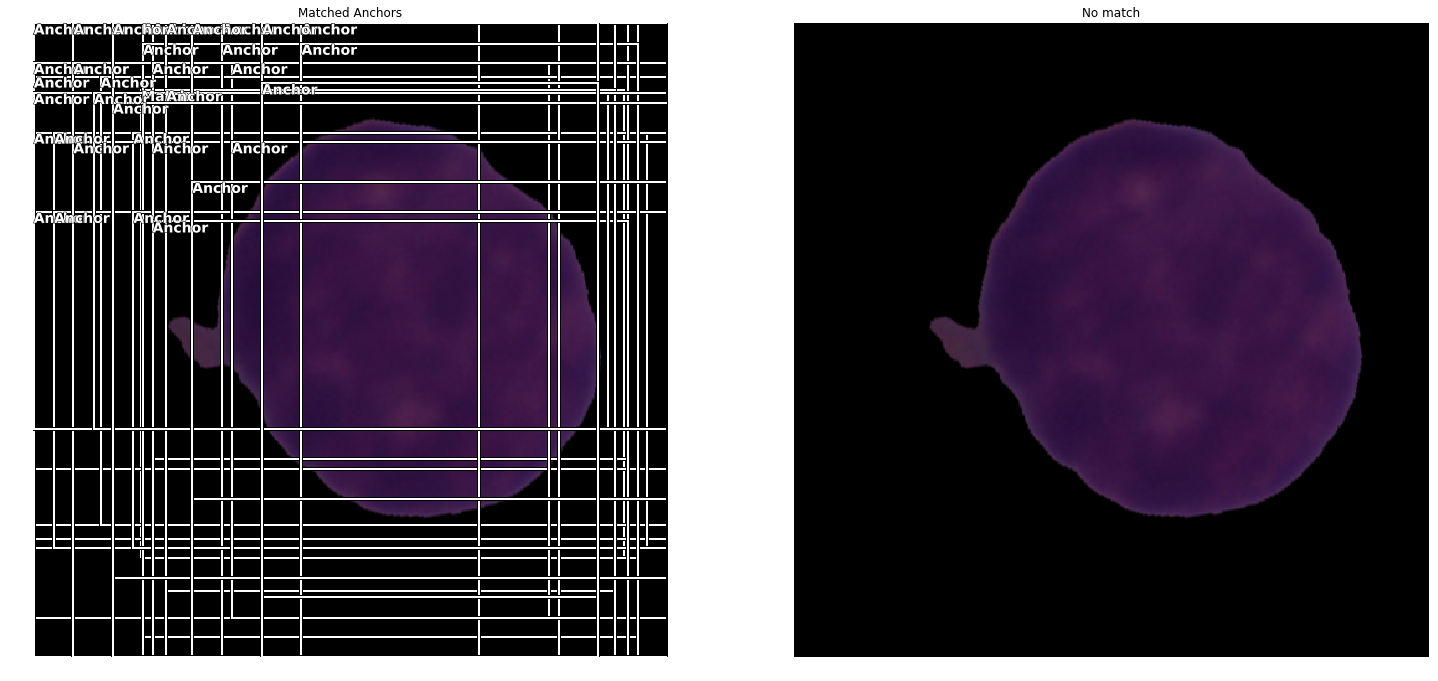

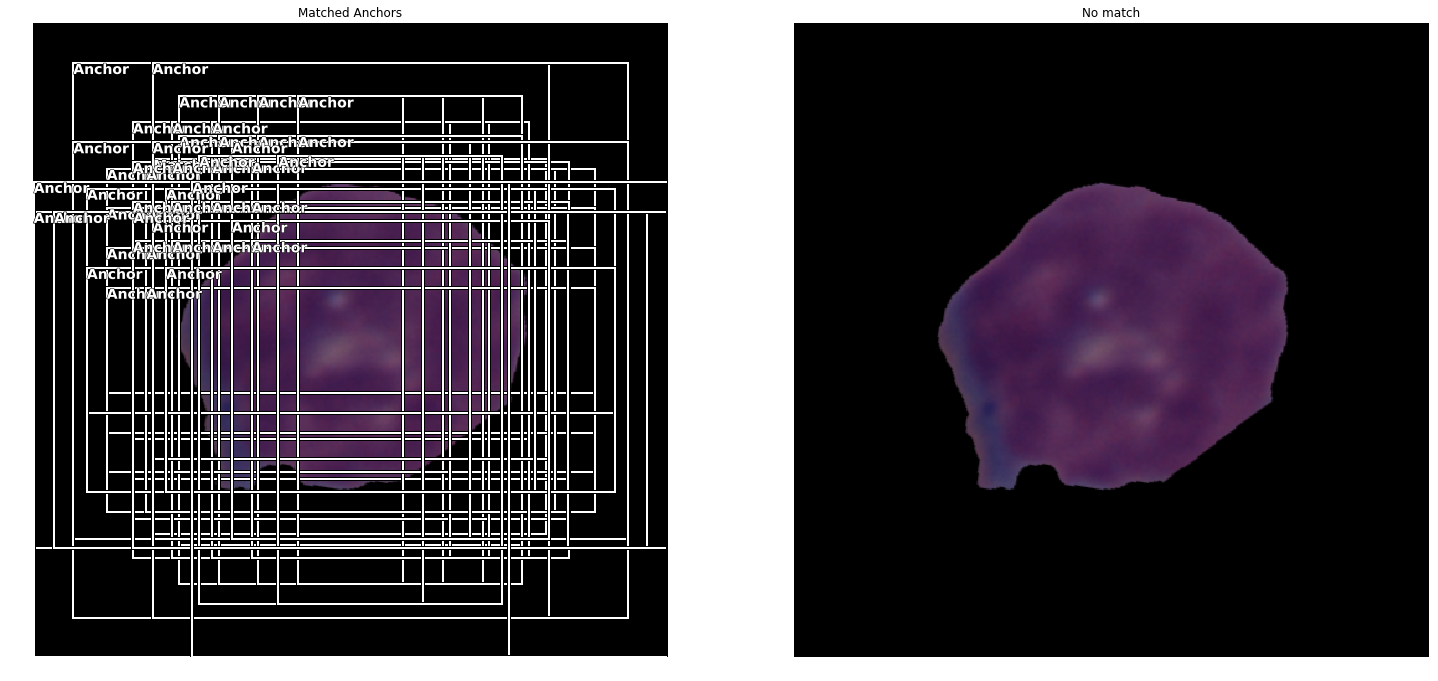

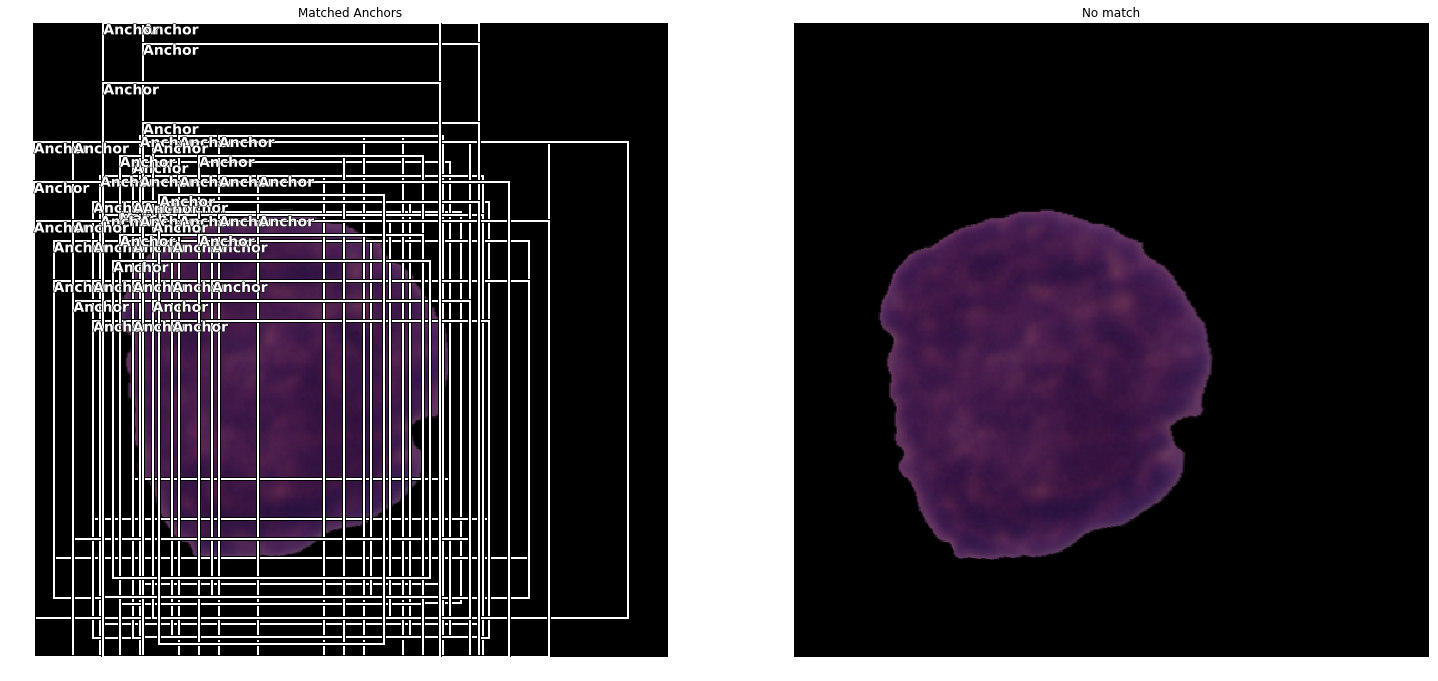

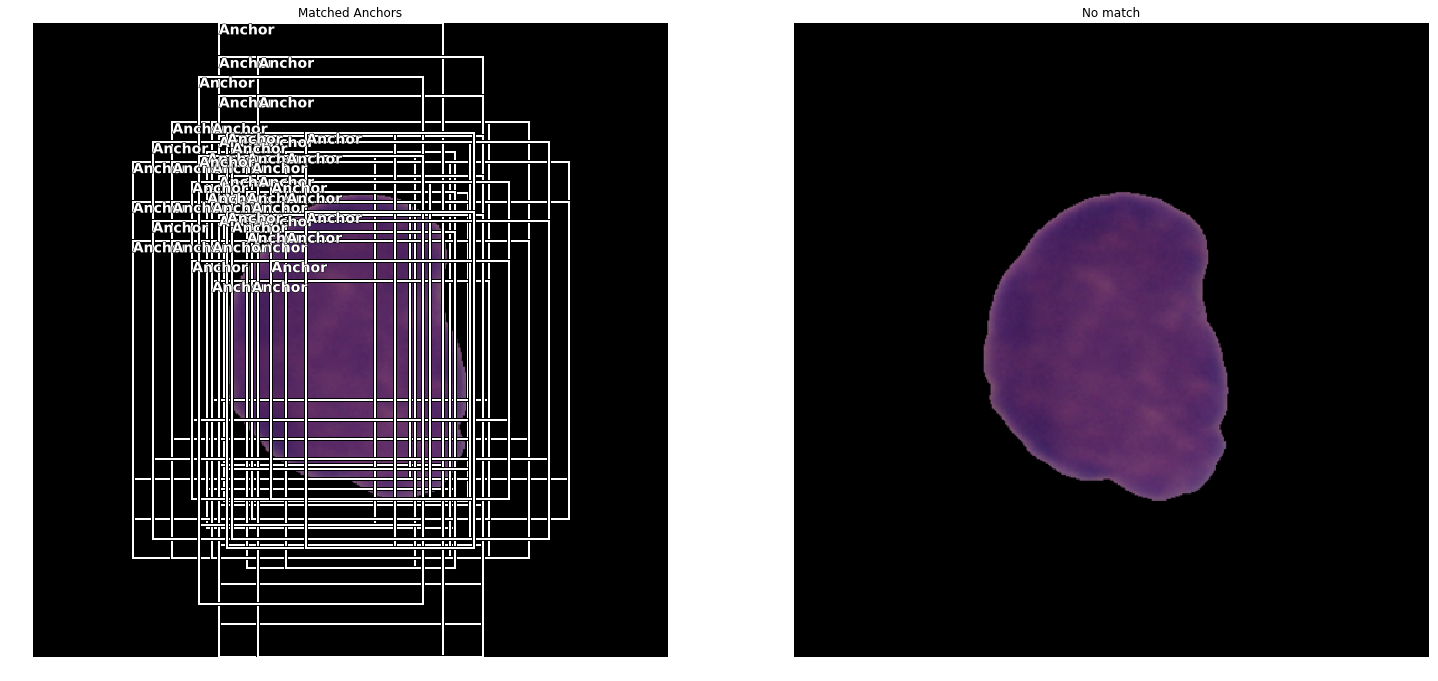

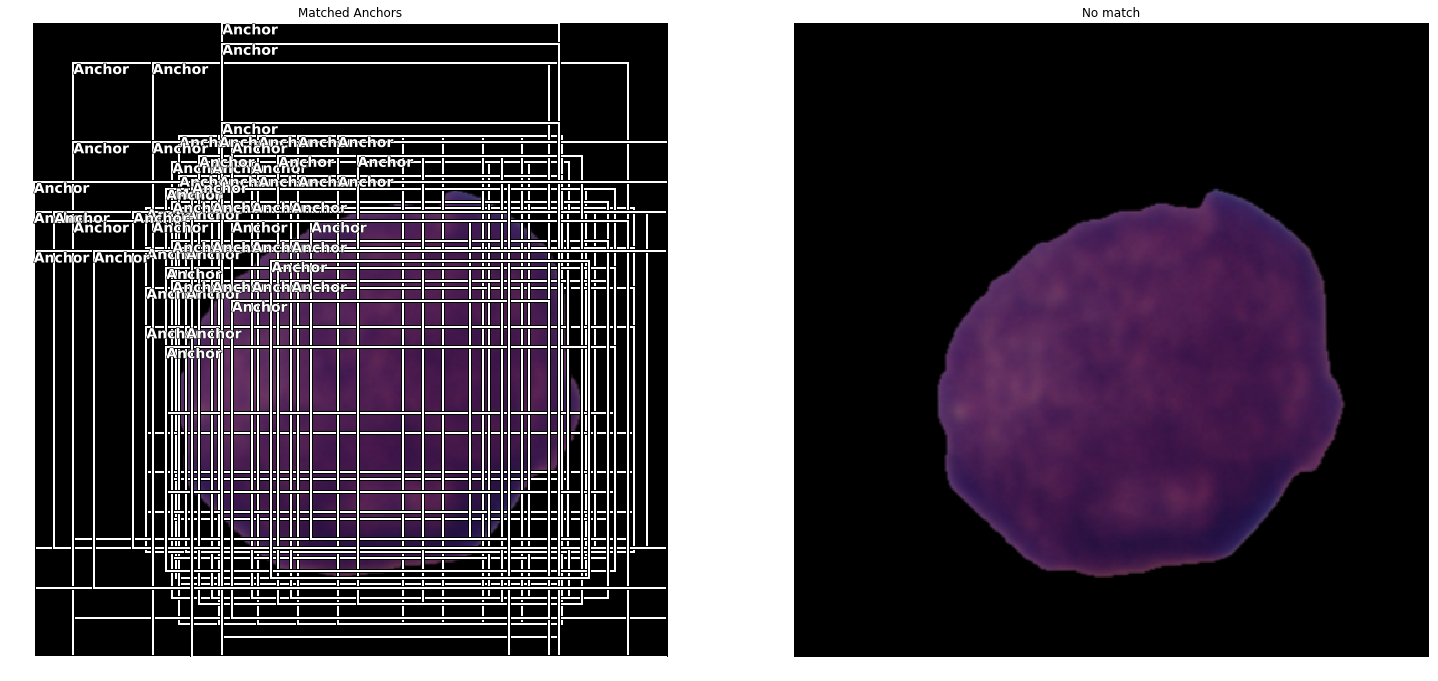

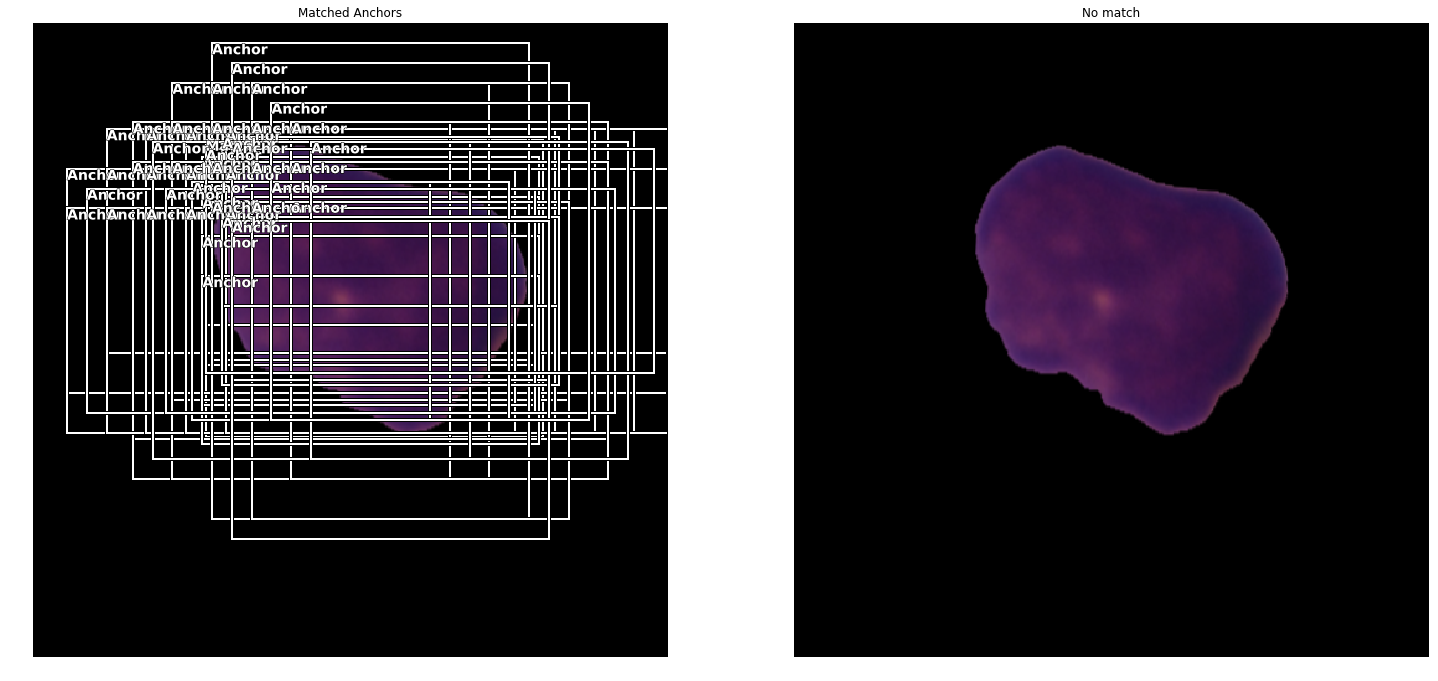

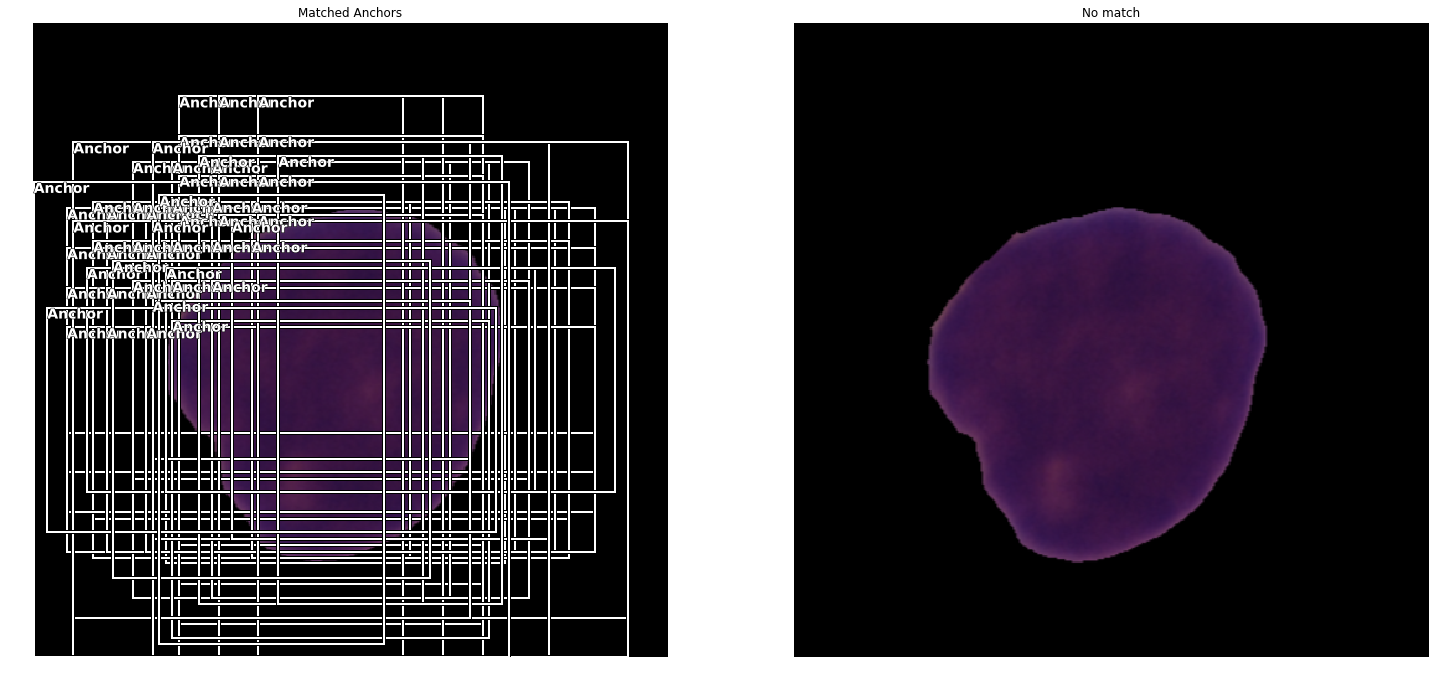

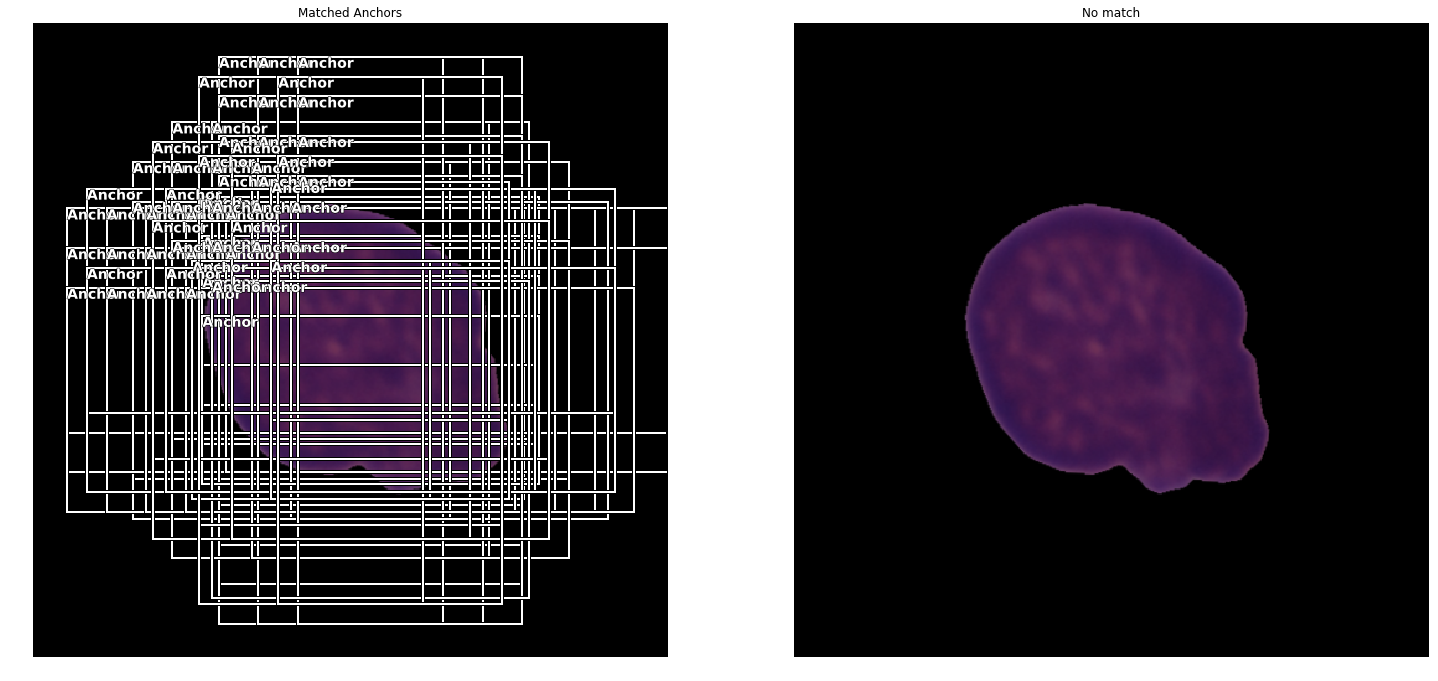

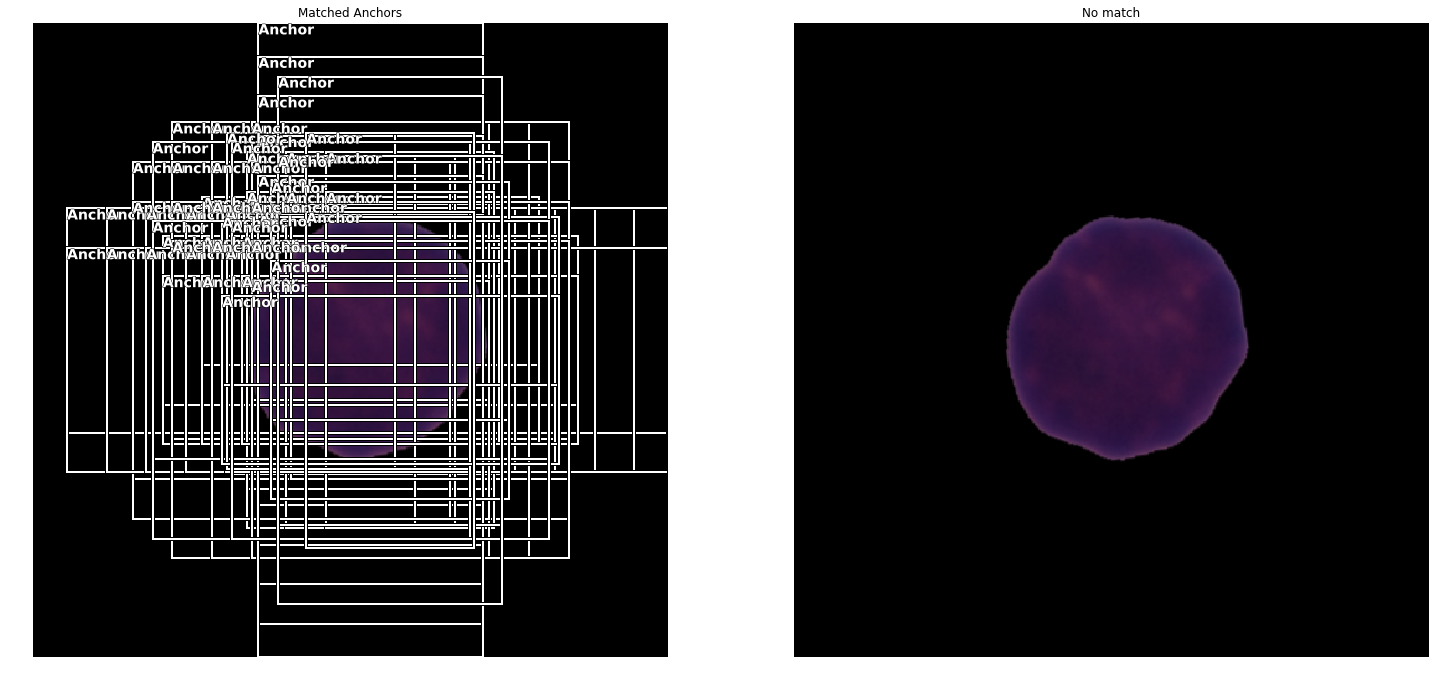

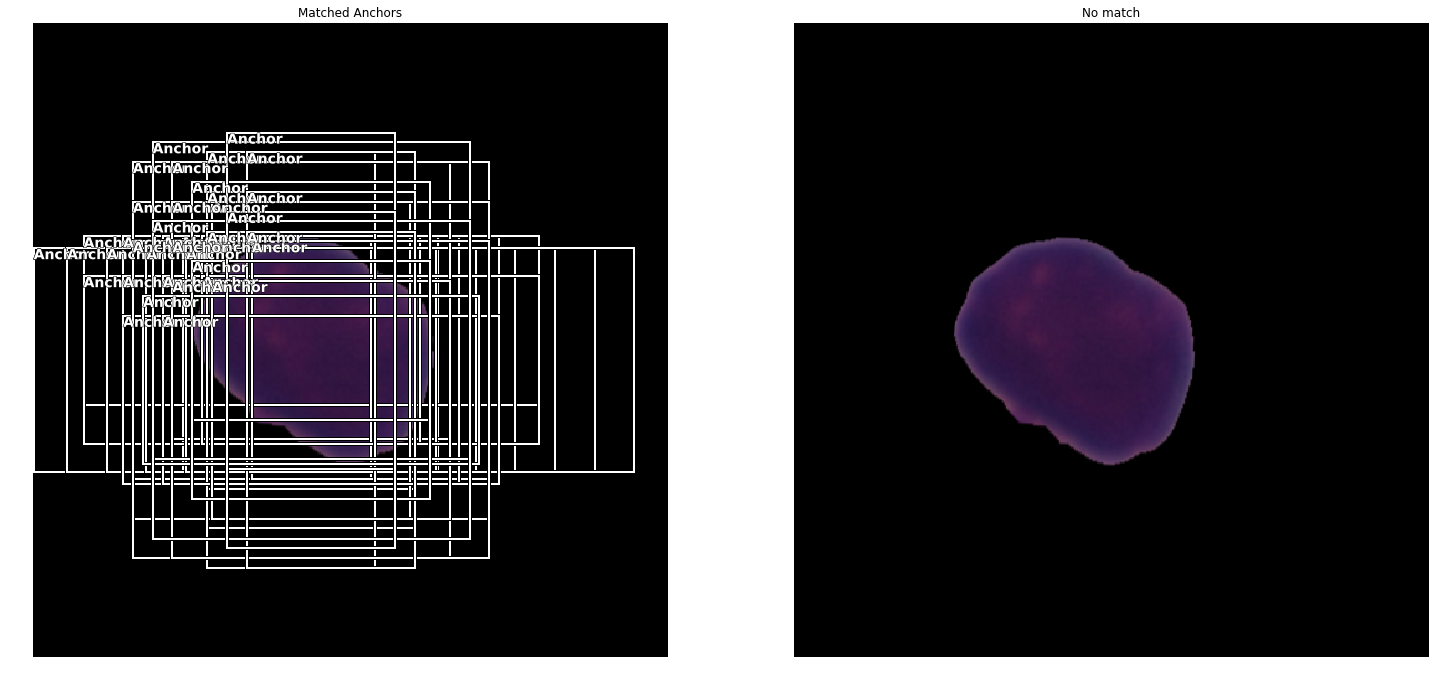

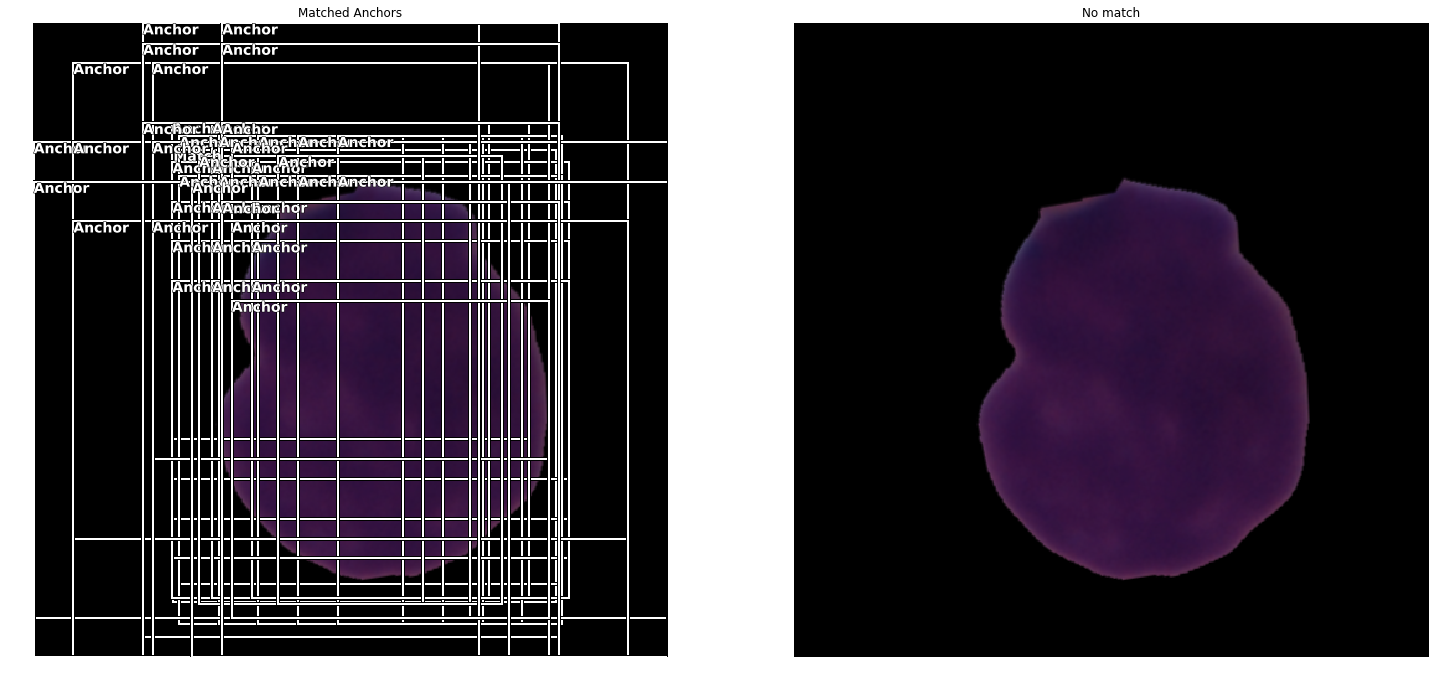

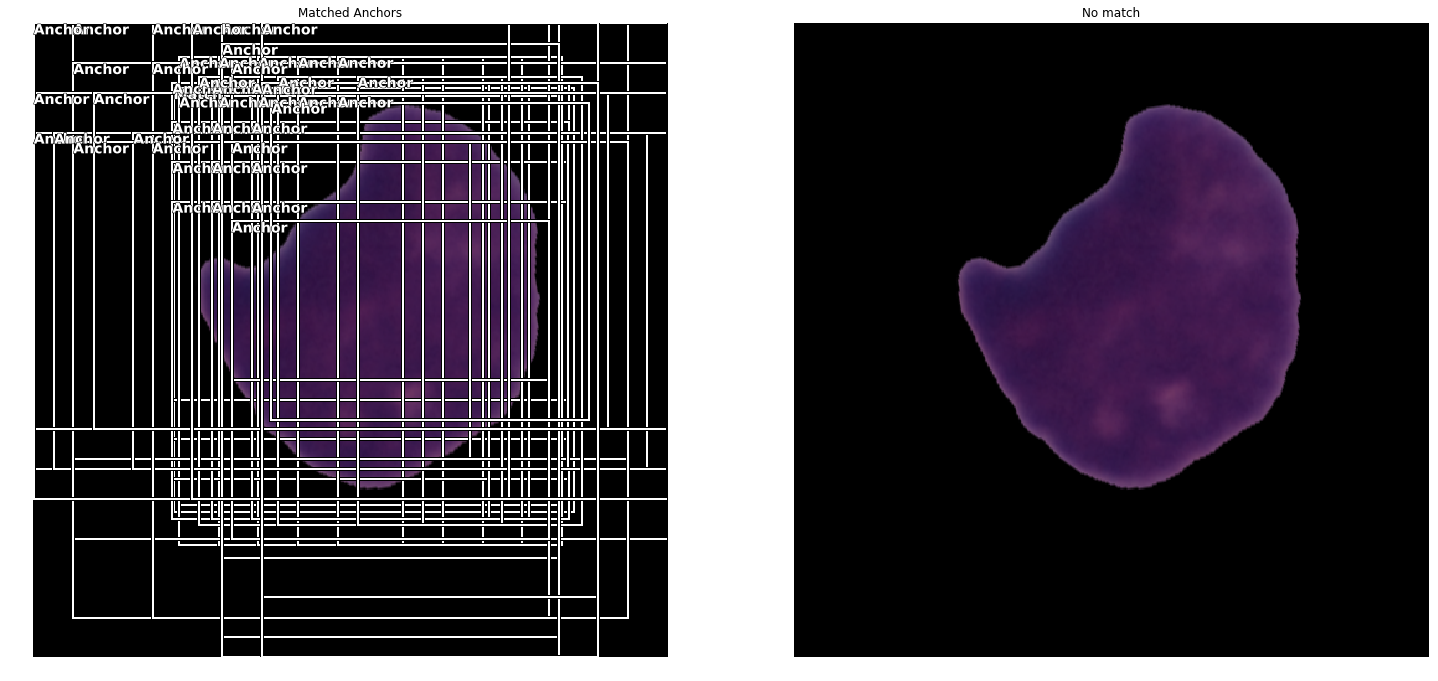

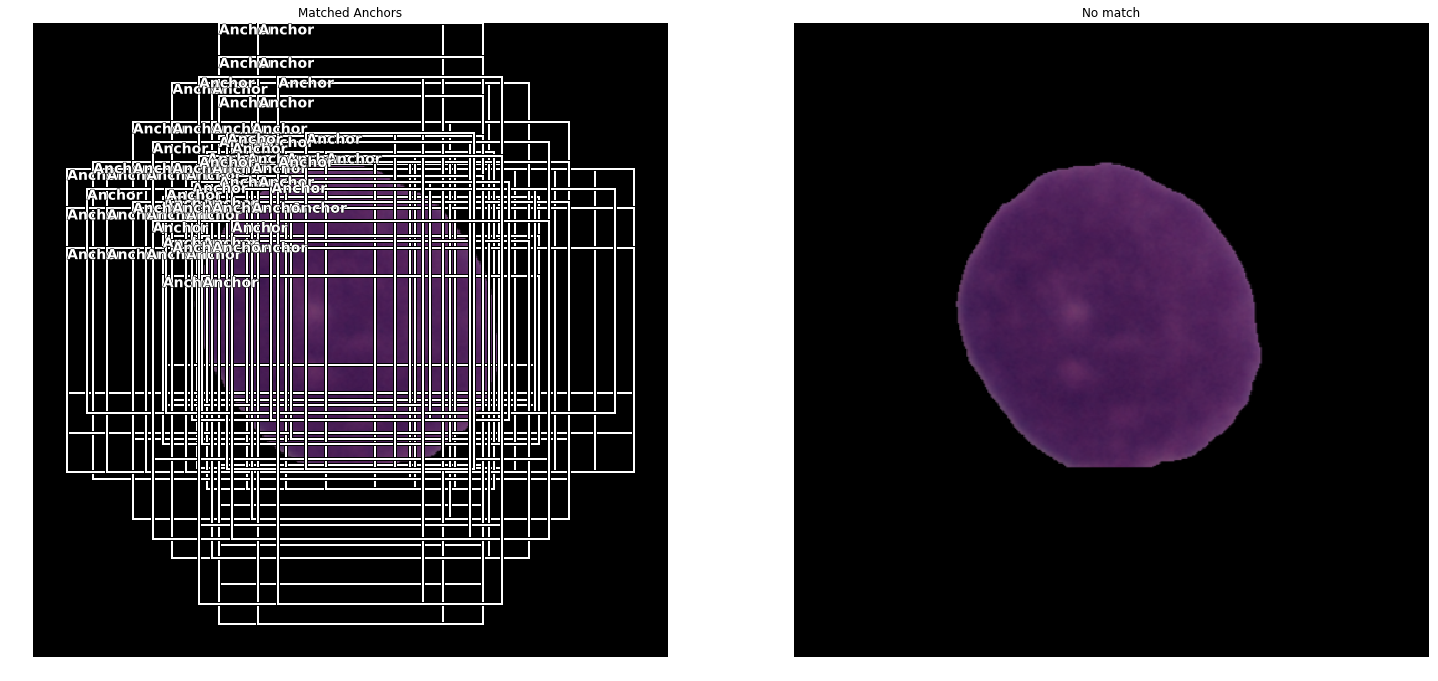

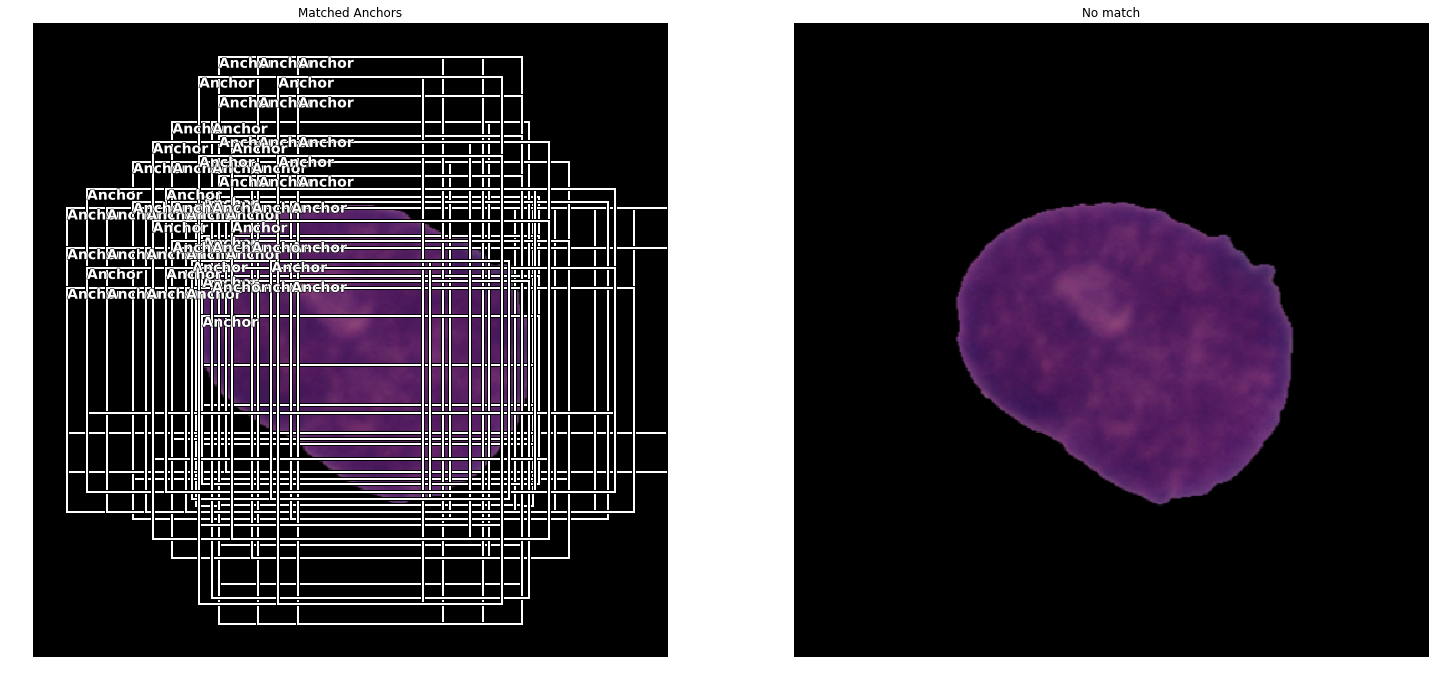

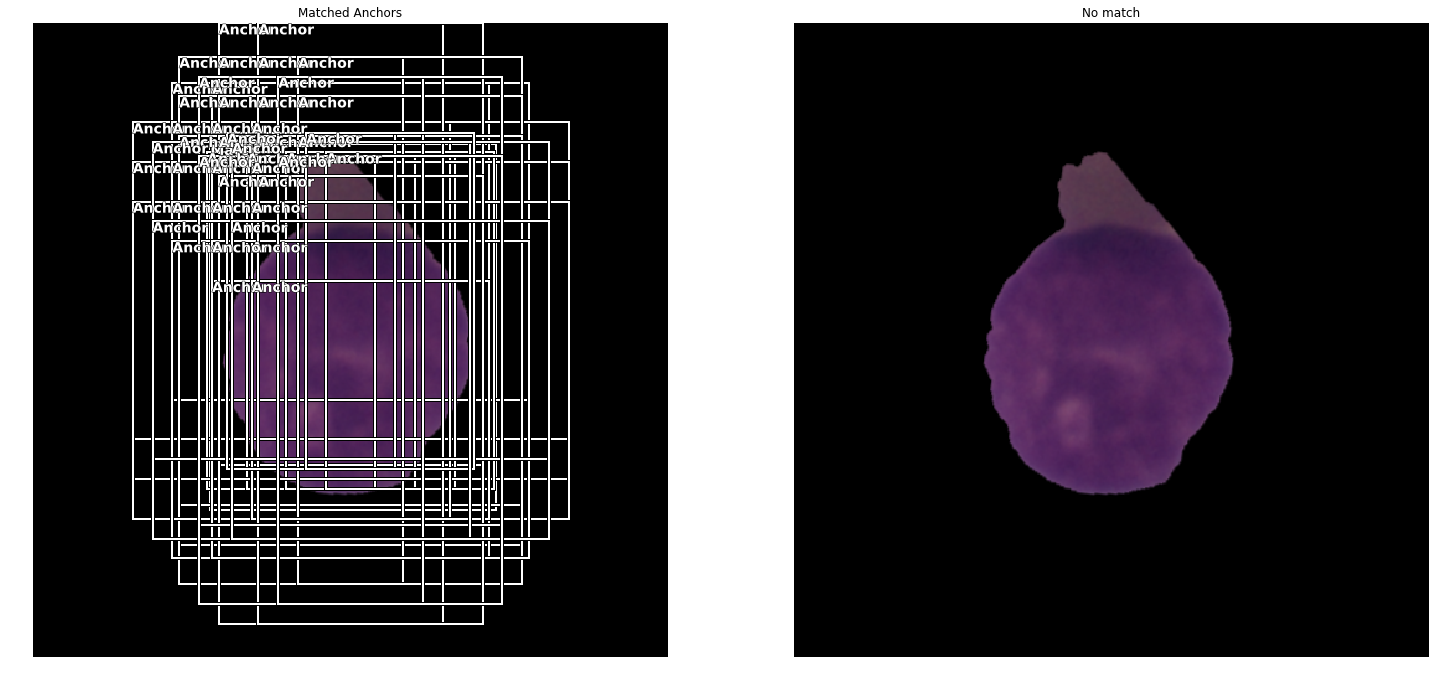

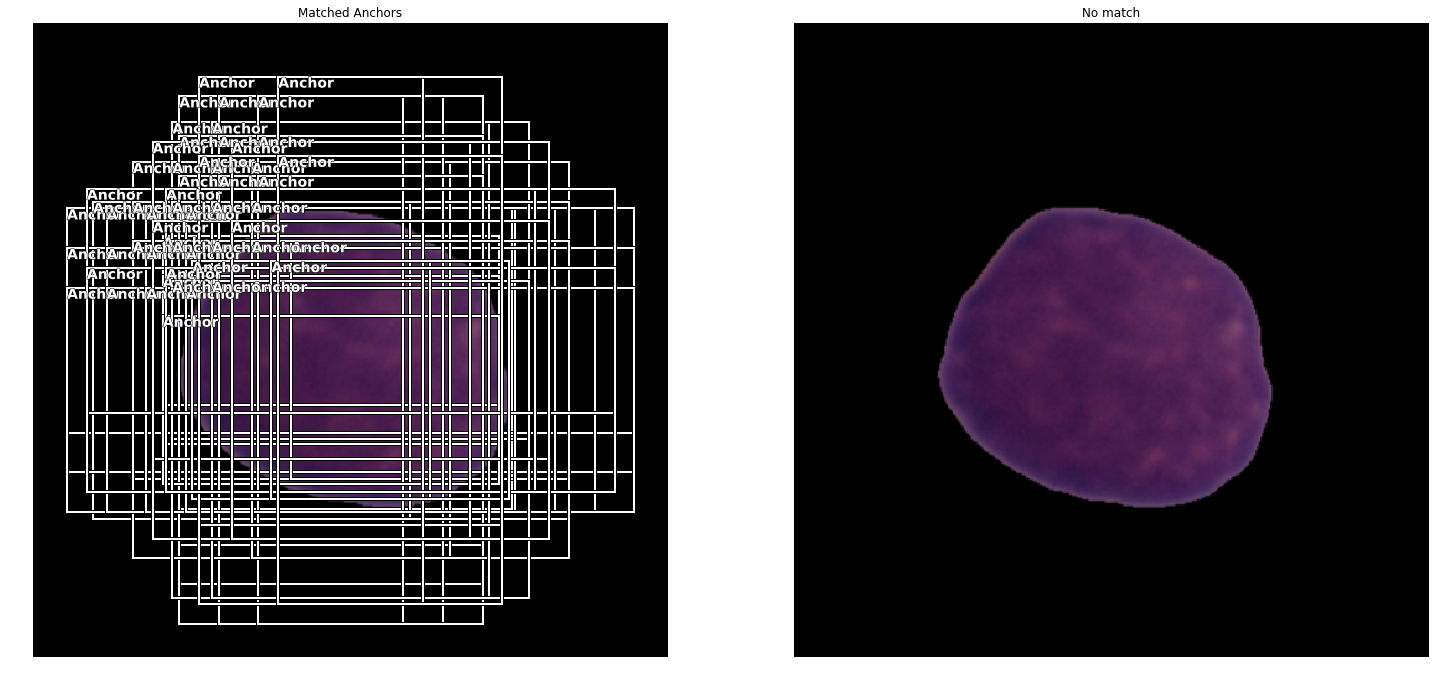

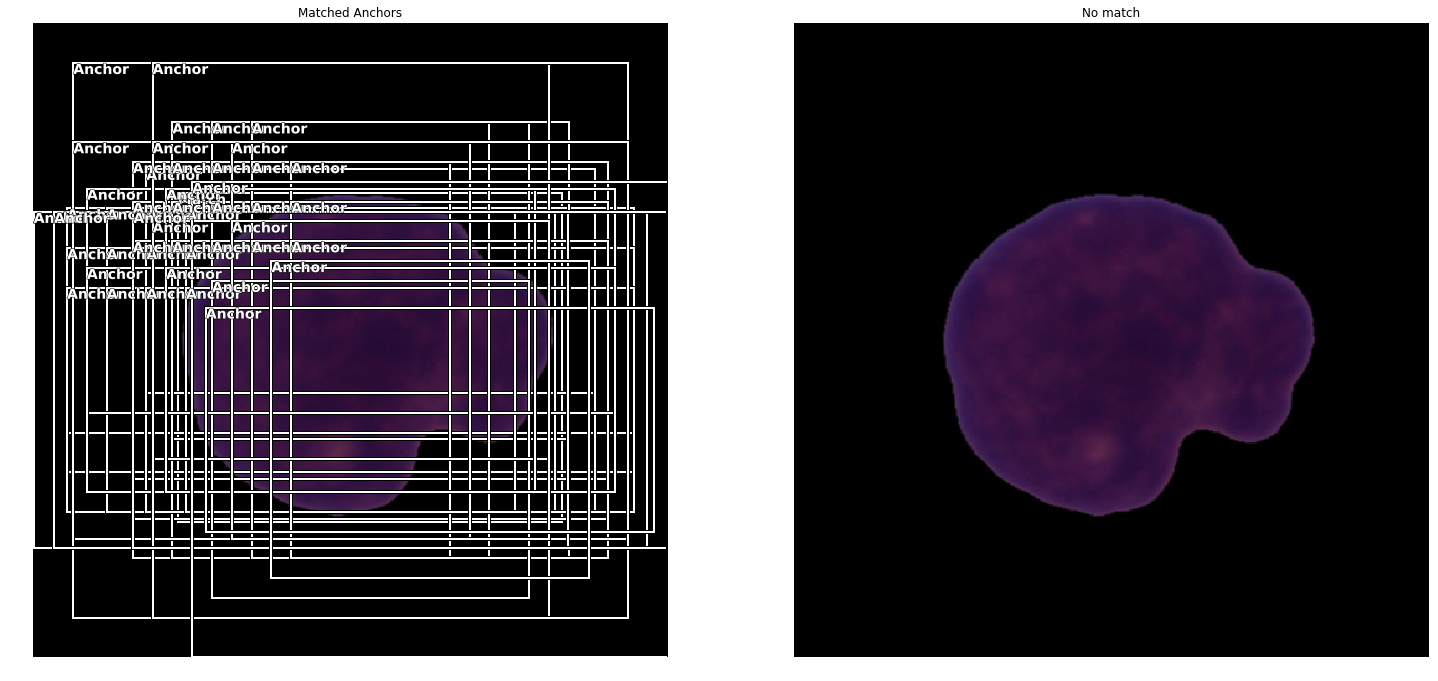

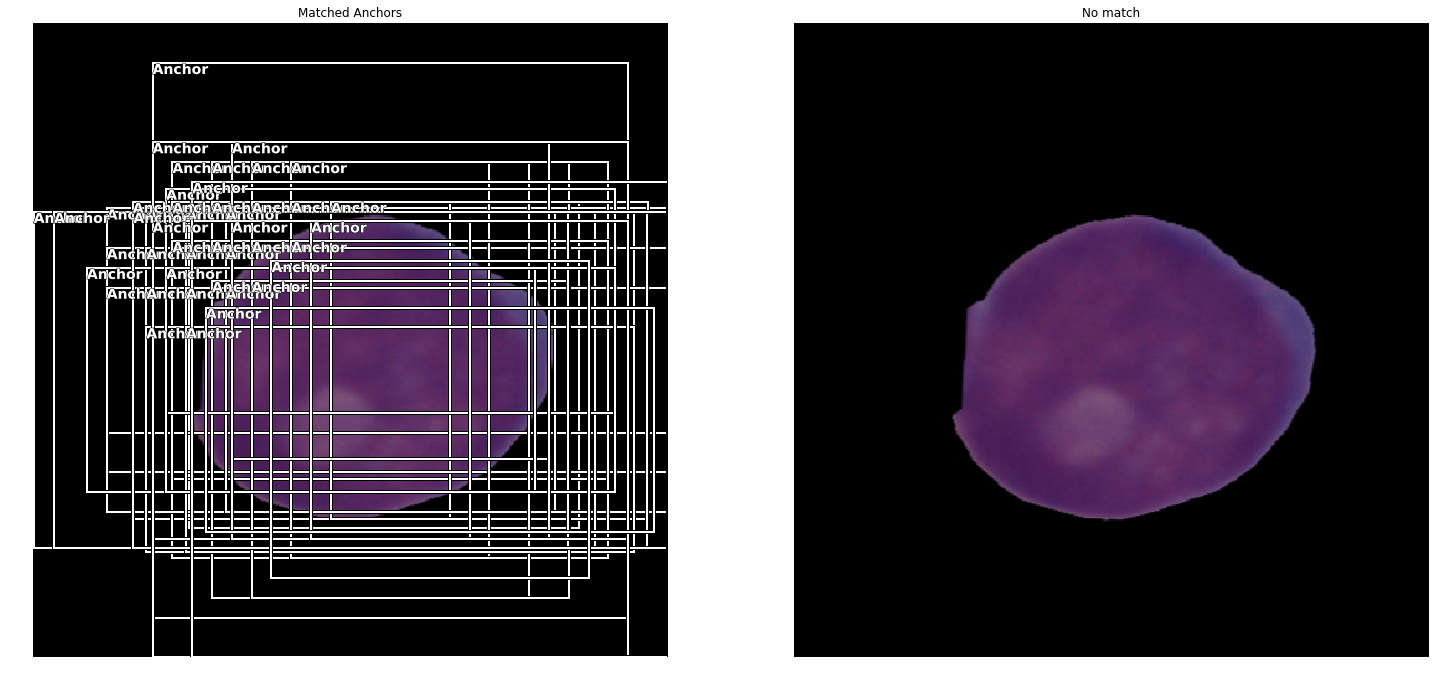

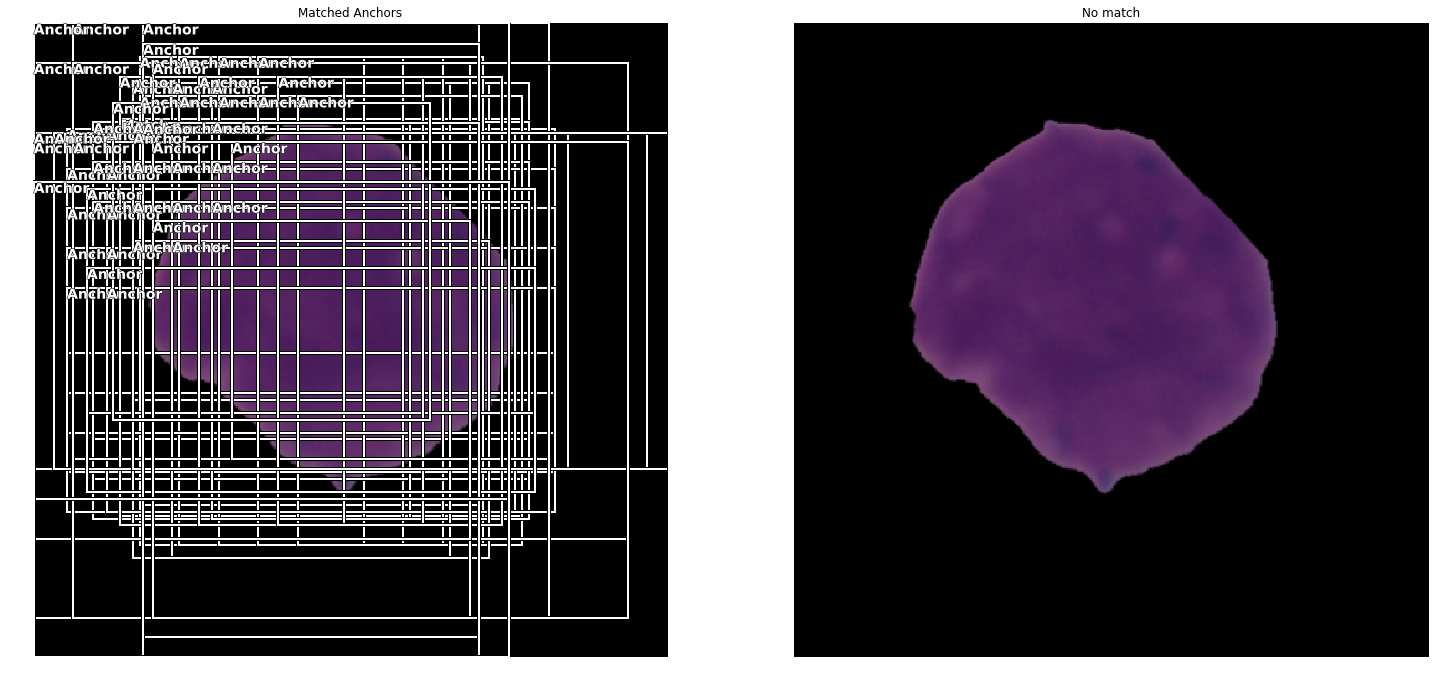

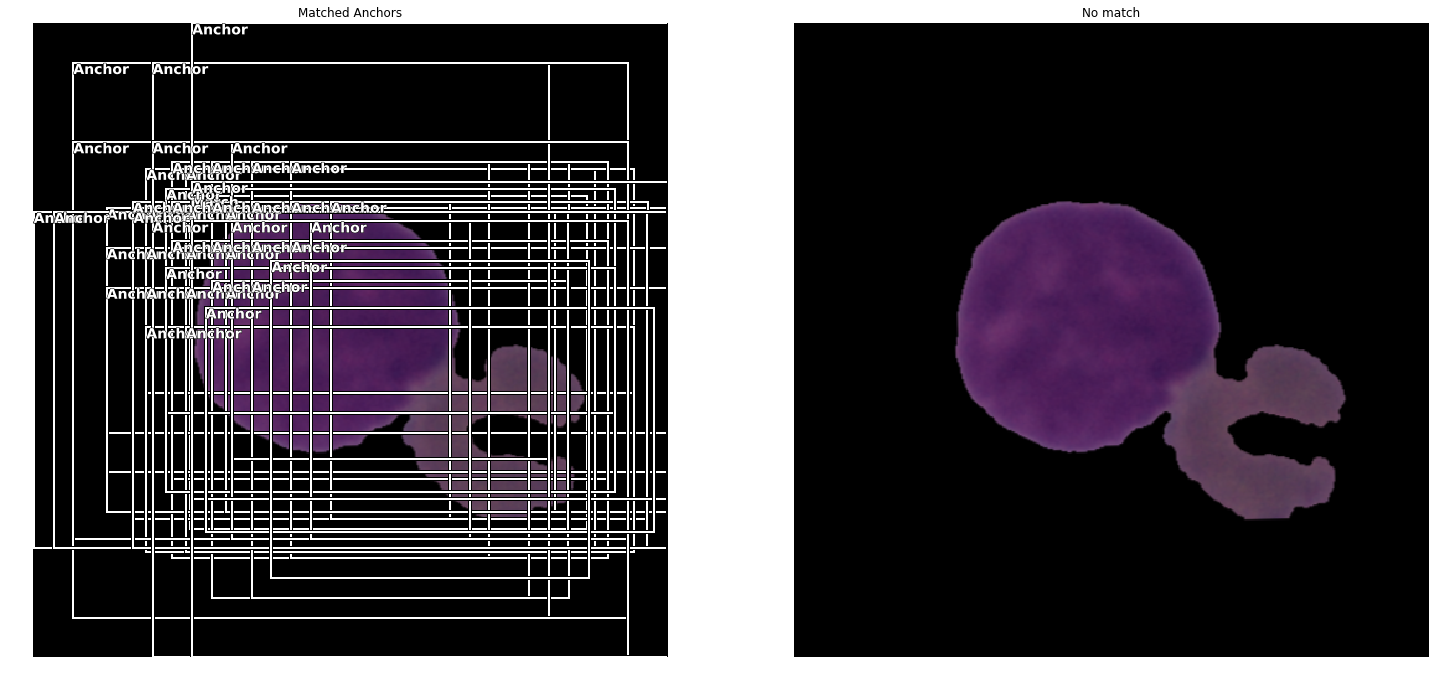

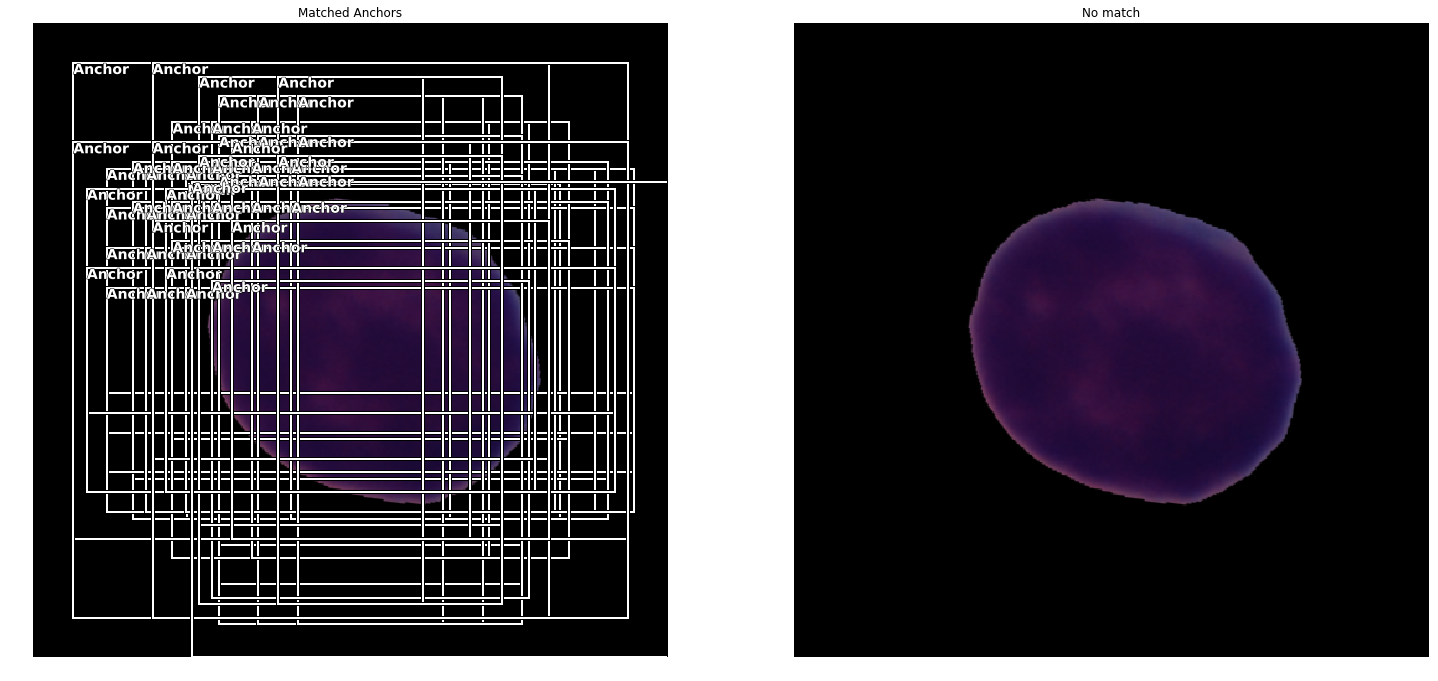

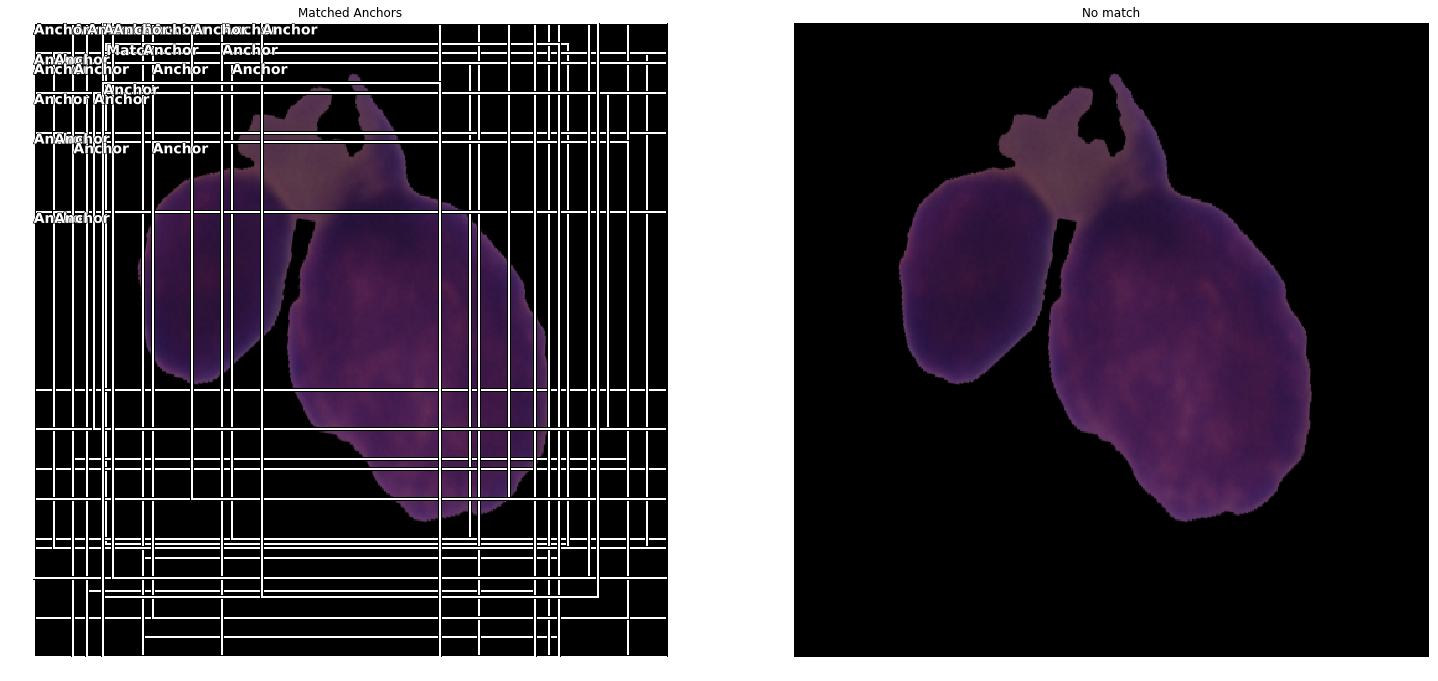

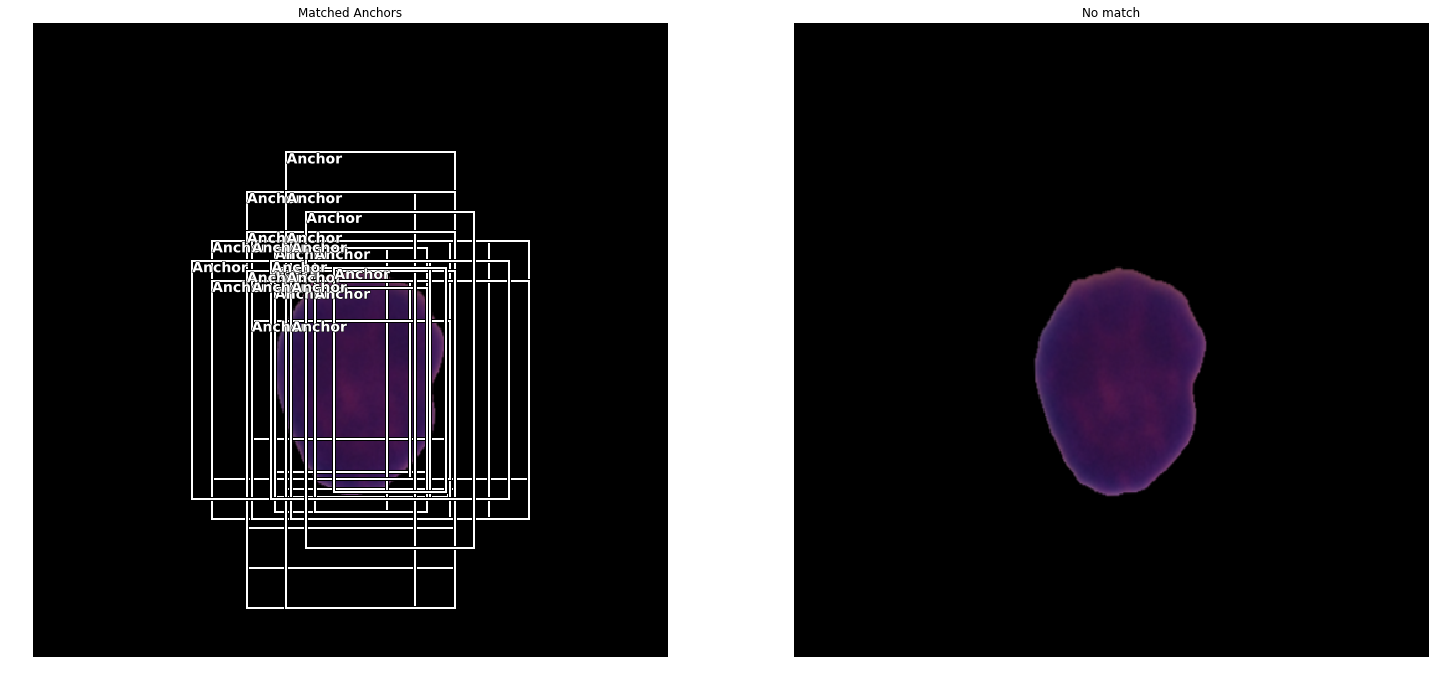

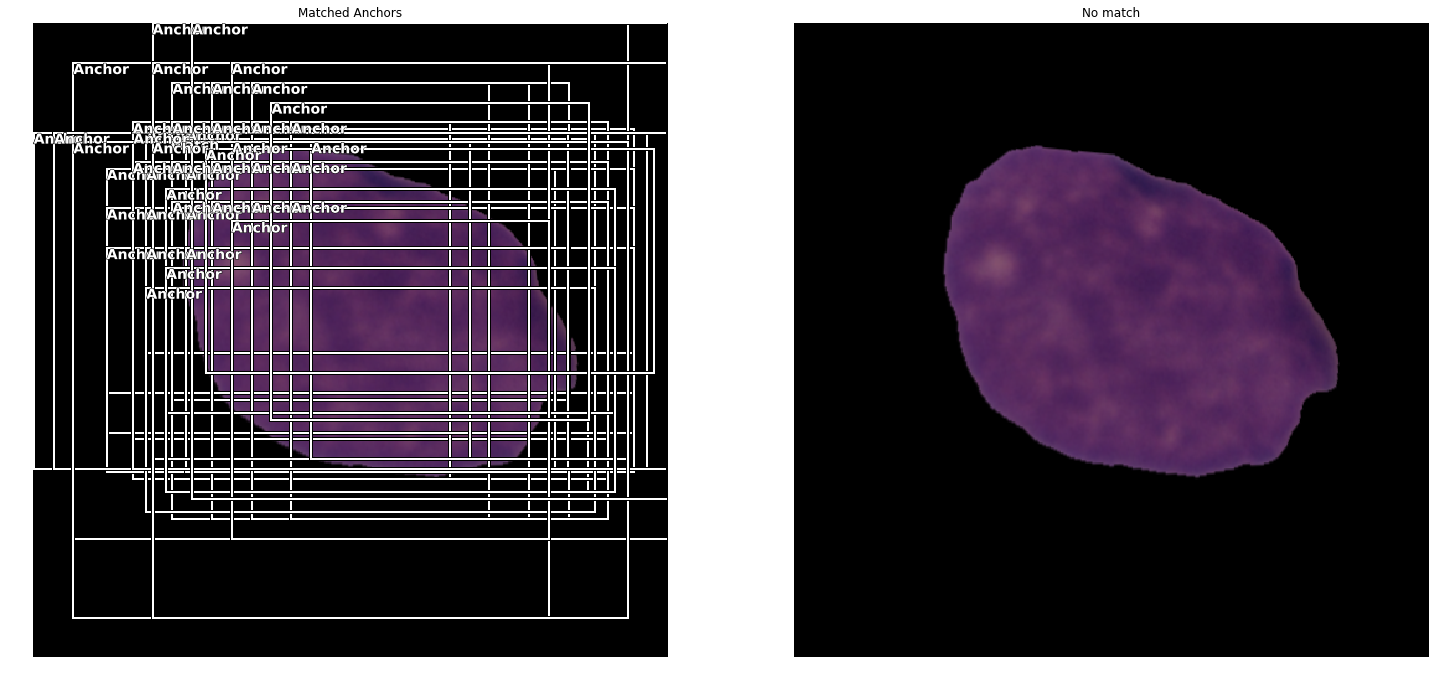

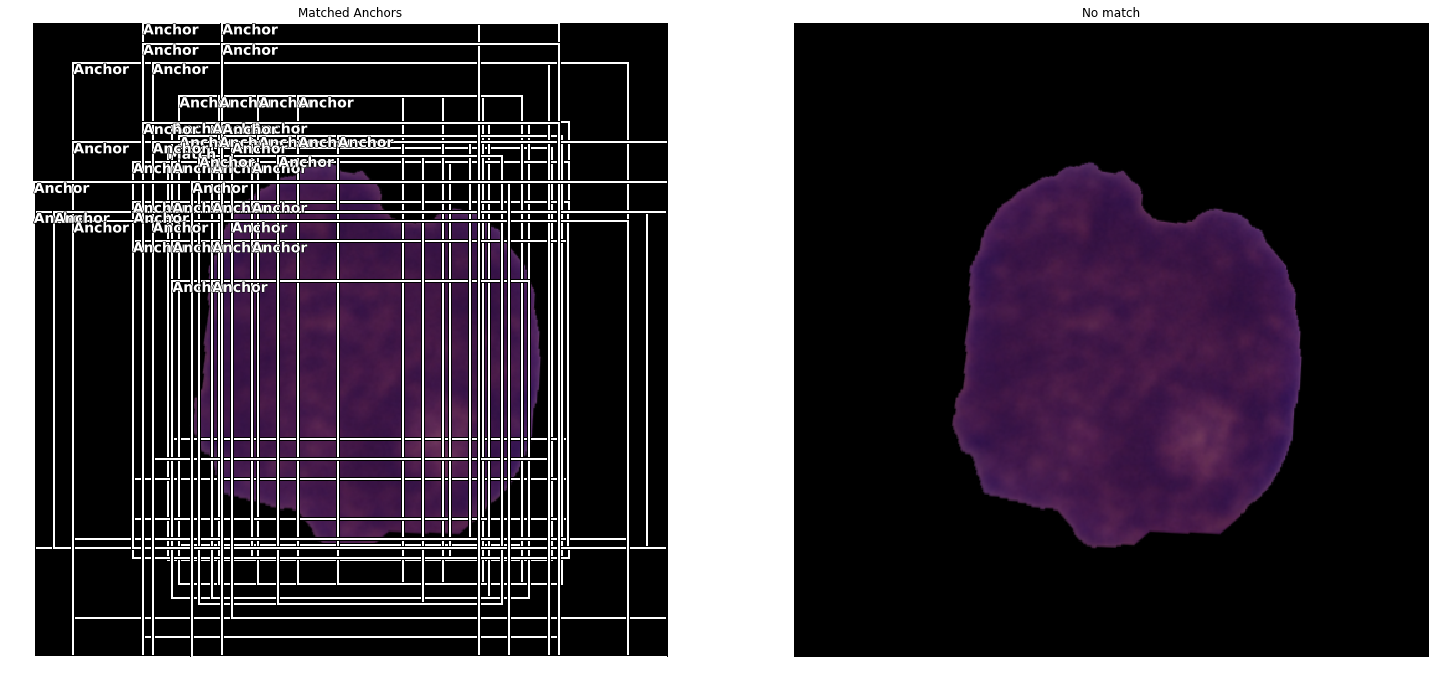

In [15]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

In [16]:
all_boxes[all_labels == 0]

array([], shape=(0, 4), dtype=float32)

In [17]:
all_boxes[all_labels == 1]

array([], shape=(0, 4), dtype=float32)

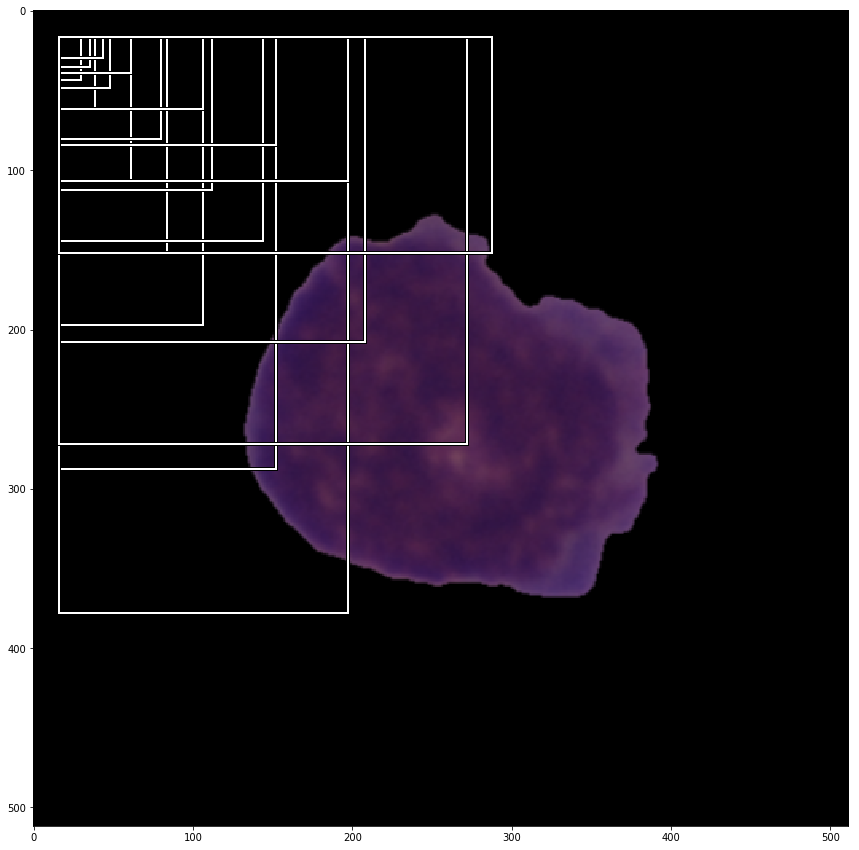

In [18]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:20]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [19]:
def error_rate(output, bbox_tgts, clas_tgts)->Rank0Tensor:
    "1 - `accuracy`"
    class_results = clas_tgts.clone() + 2
    bbox_gt_batch, class_gt_batch = bbox_tgts, clas_tgts
    class_pred_batch, bbox_pred_batch = output[:2]

    id = 0
    for bbox_gt, class_gt, clas_pred, bbox_pred in \
            list(zip(bbox_gt_batch, class_gt_batch, class_pred_batch, bbox_pred_batch)):

        bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, 0.5)
        if bbox_pred is None:  # or len(preds) > 3 * len(bbox_gt):
            continue
        to_keep = nms(bbox_pred, scores, 0.6)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

        class_results[id] = 2 if preds[:5].float().mean() > 0.5 else 1
        id += 1

    return 1 - (class_results.long()==clas_tgts.long()).float().mean()

In [20]:
crit = RetinaNetFocalLoss(anchors)

In [21]:
encoder = create_body(models.resnet50, True, -2)

In [22]:
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=21, sizes=[16, 8, 4], chs=128, final_bias=-4., n_conv=3)

In [23]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics], #BBMetrics, ShowGraph
                metrics=[voc, error_rate]
               )

In [24]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


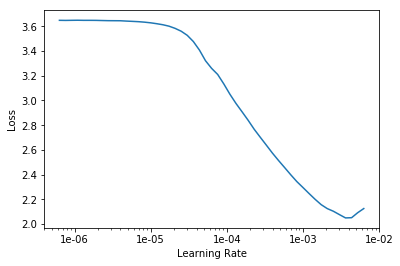

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(3, 1e-3)

In [27]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4)

In [28]:
learn.fit_one_cycle(10, 1e-4)

In [29]:
learn.fit_one_cycle(10, 1e-4)

/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


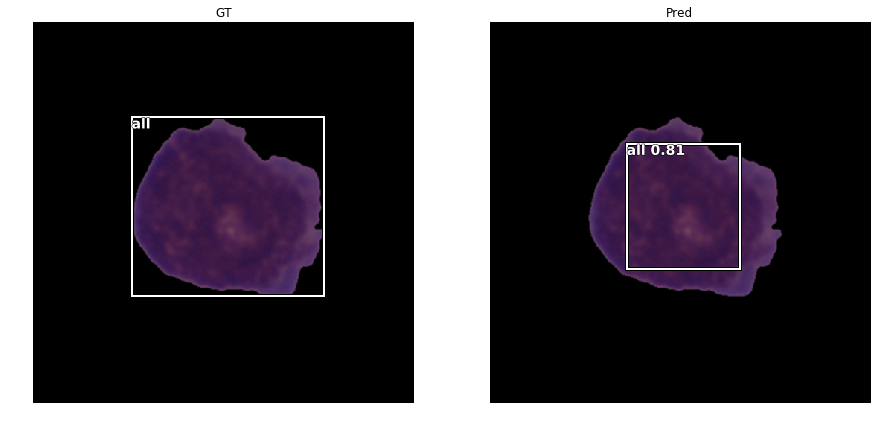

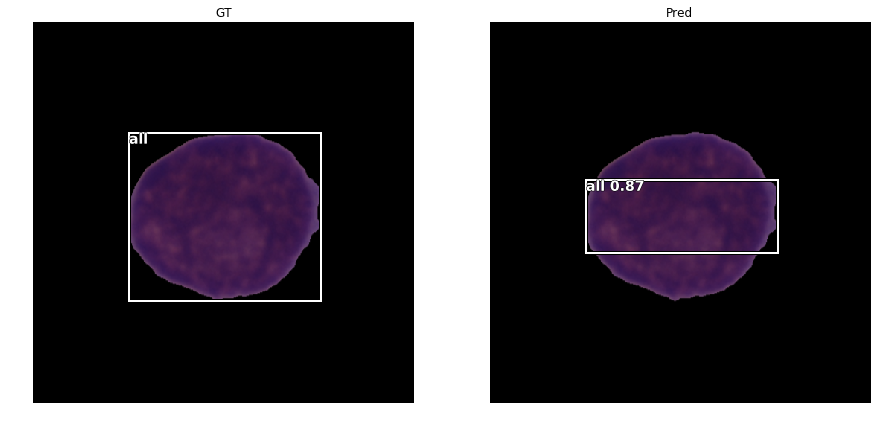

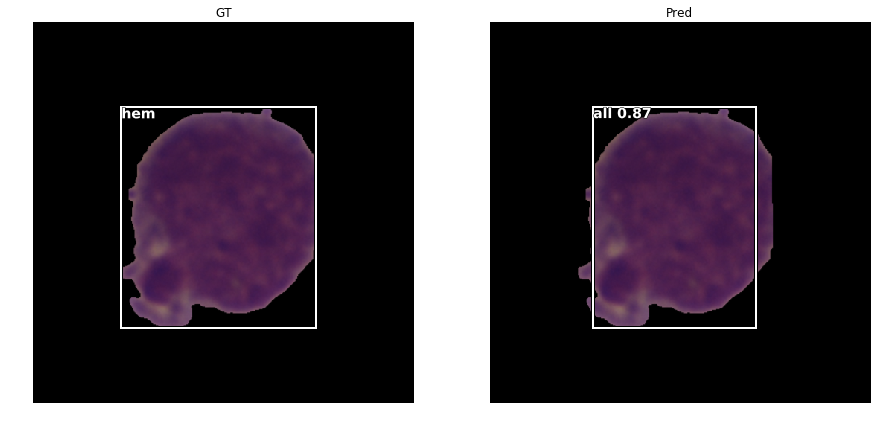

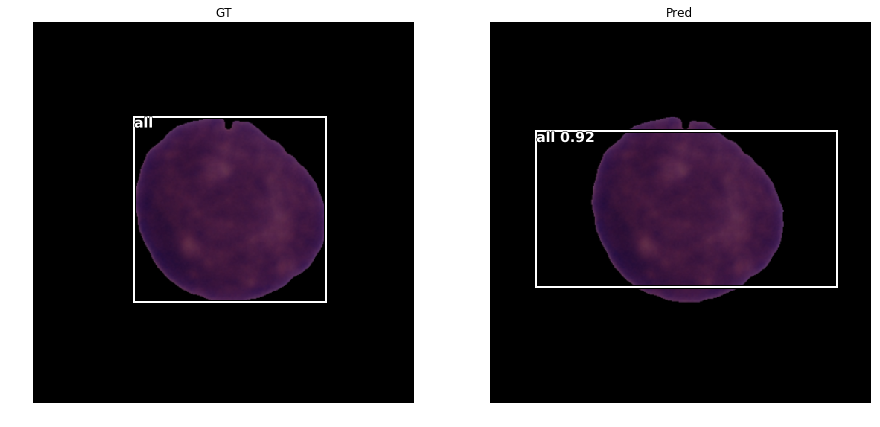

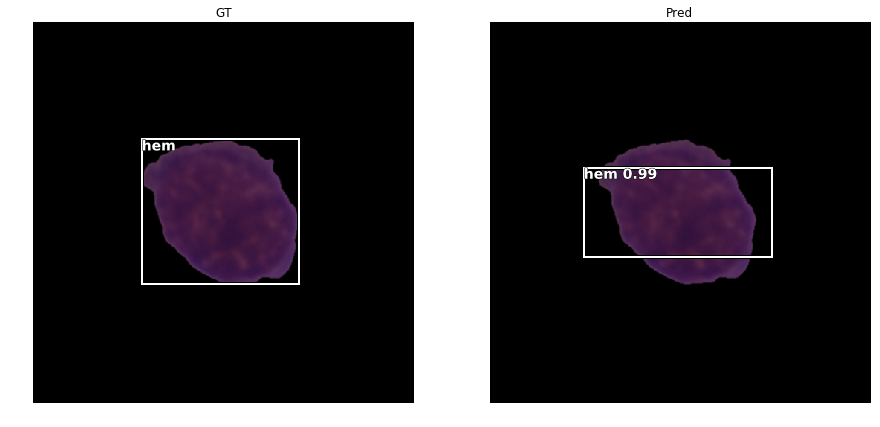

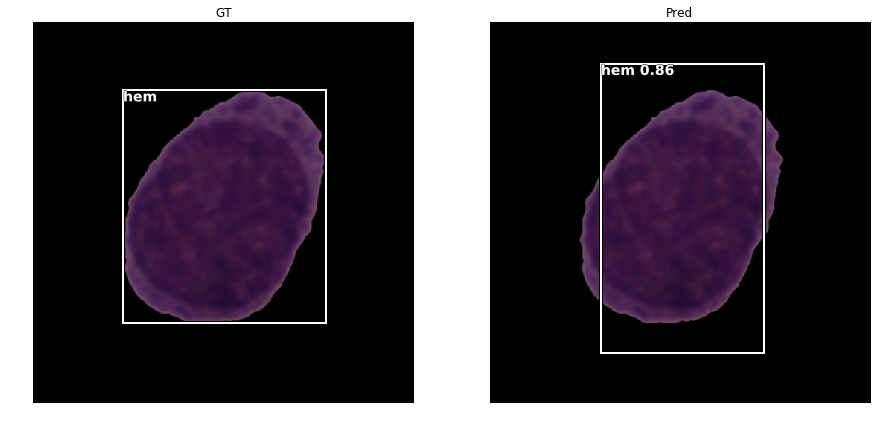

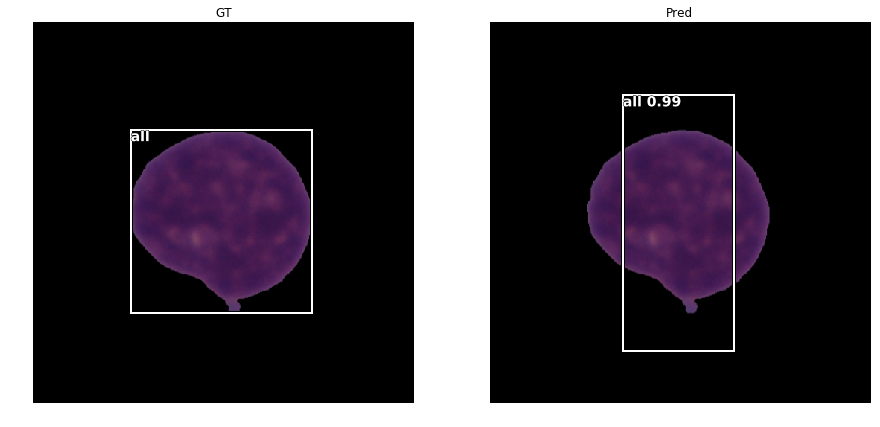

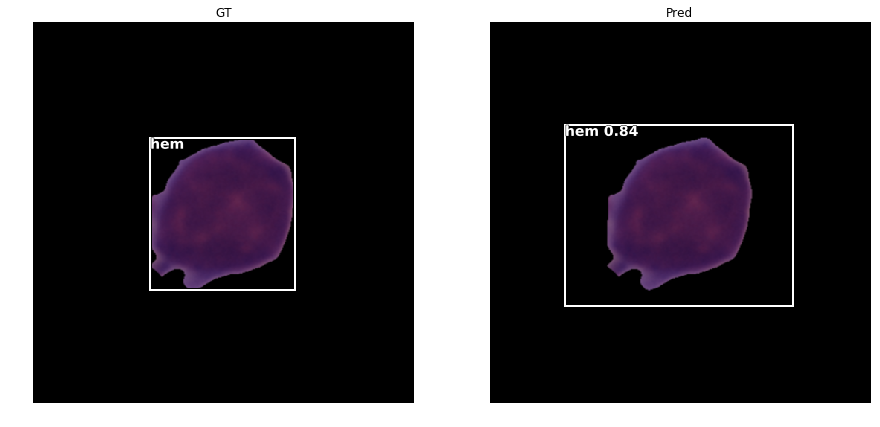

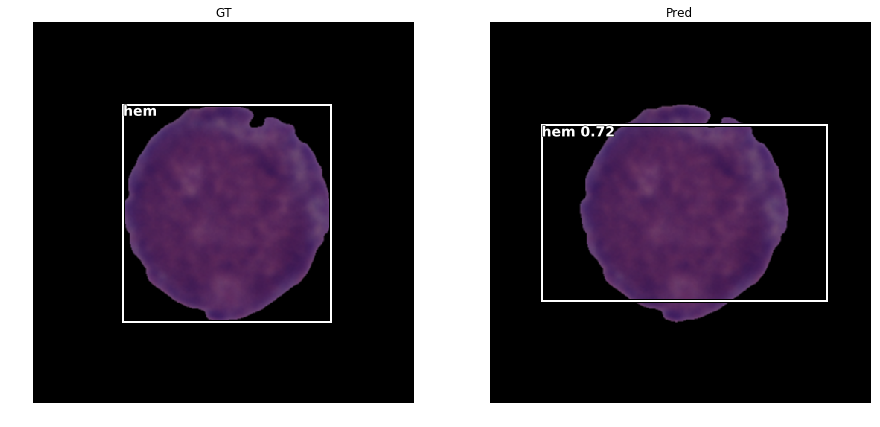

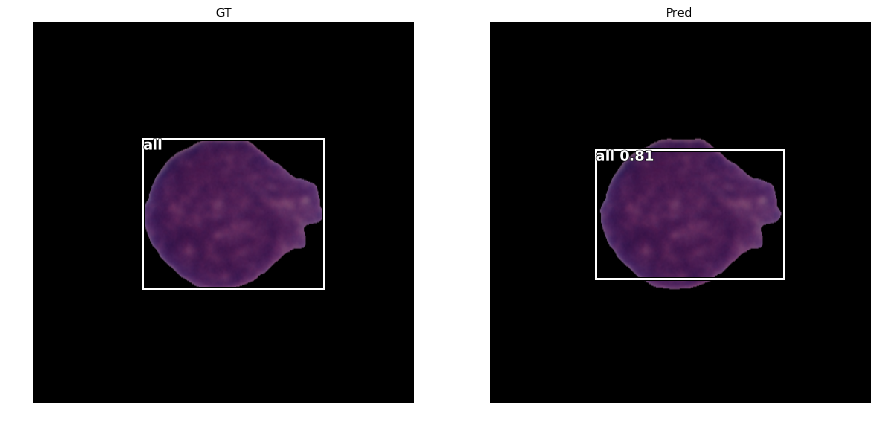

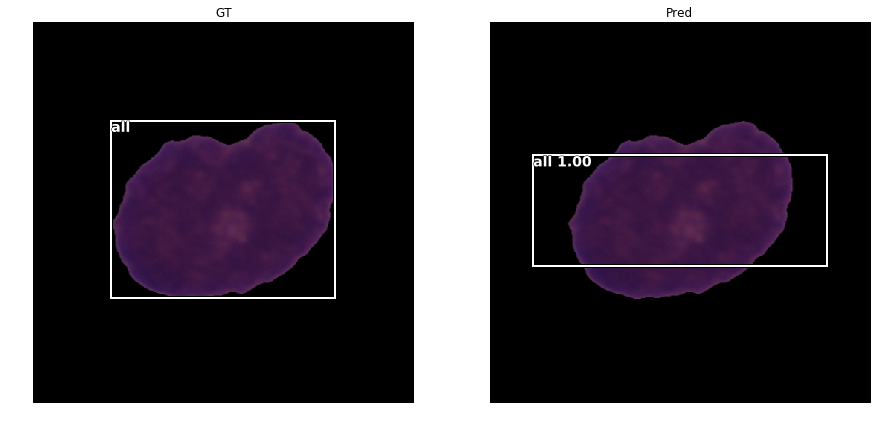

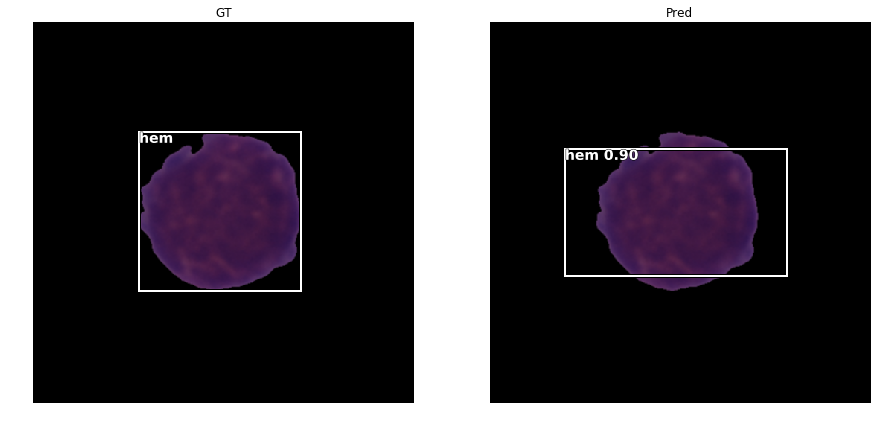

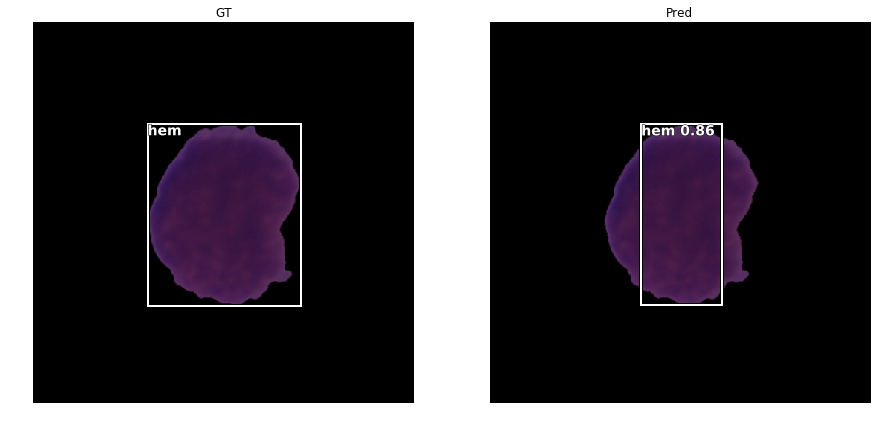

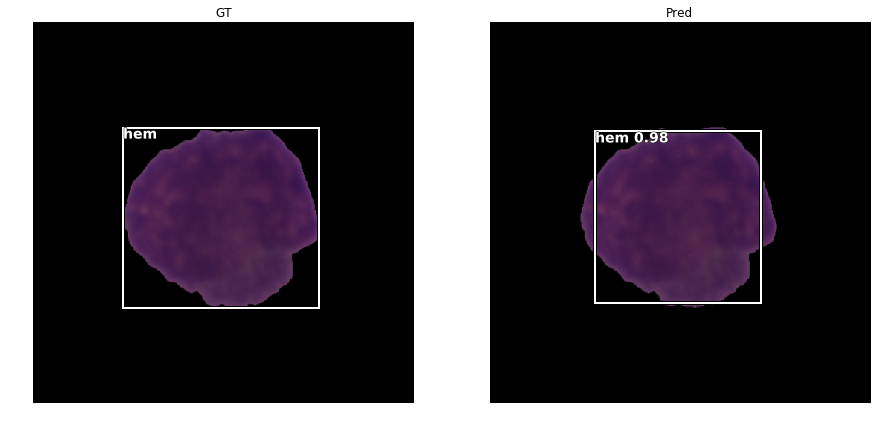

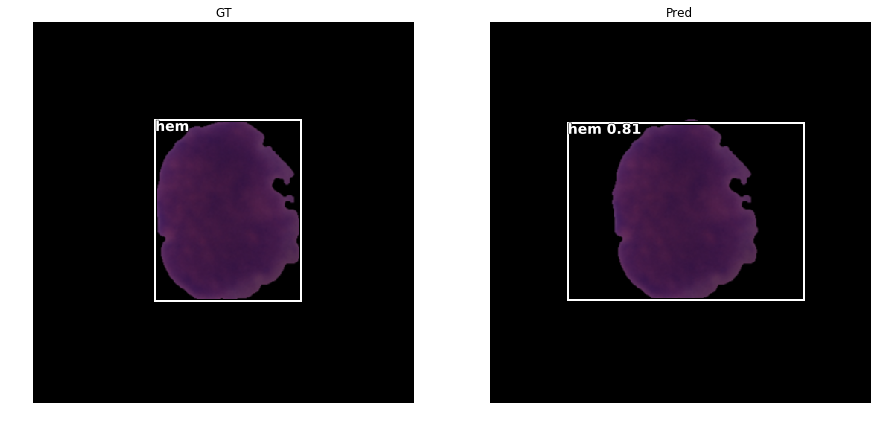

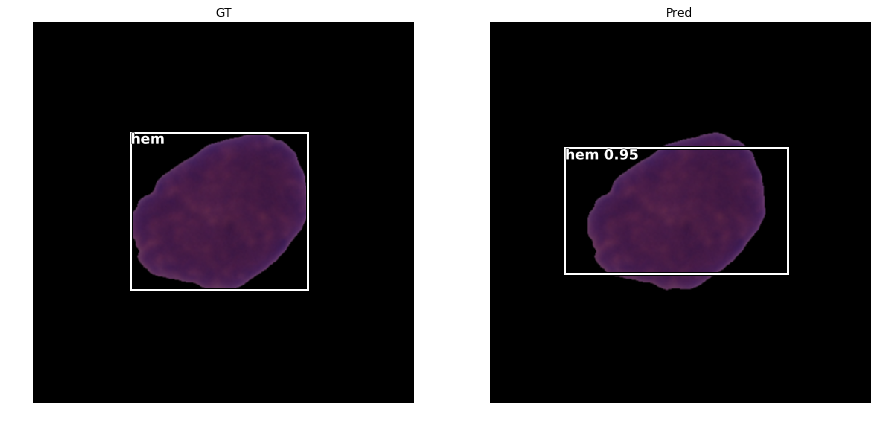

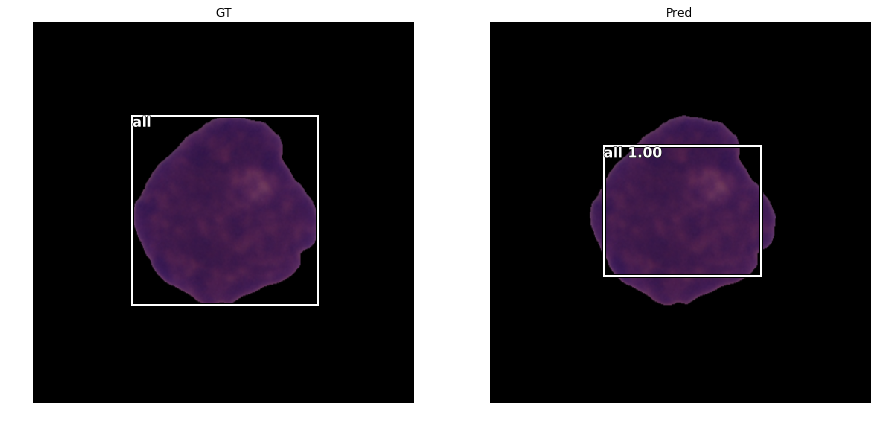

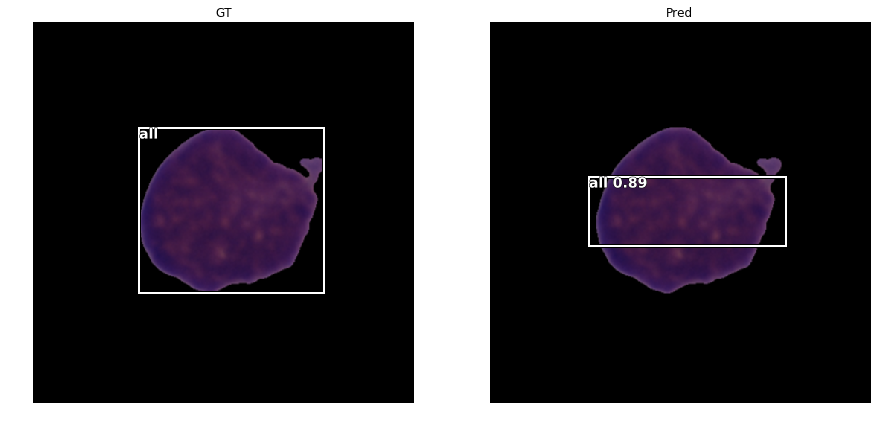

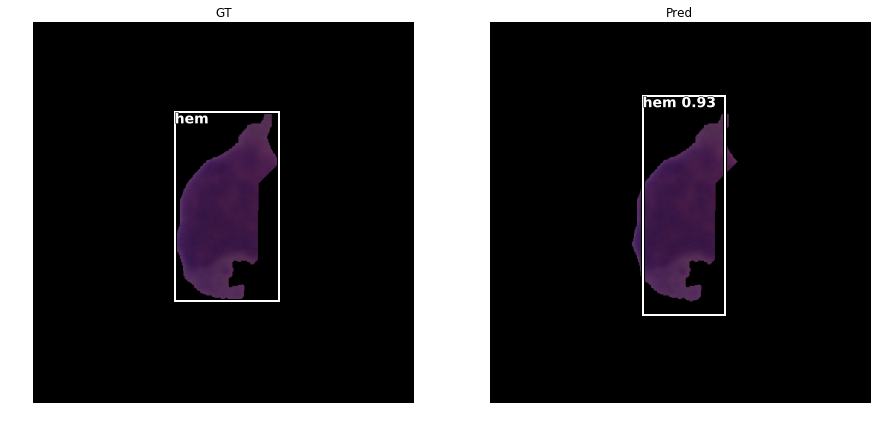

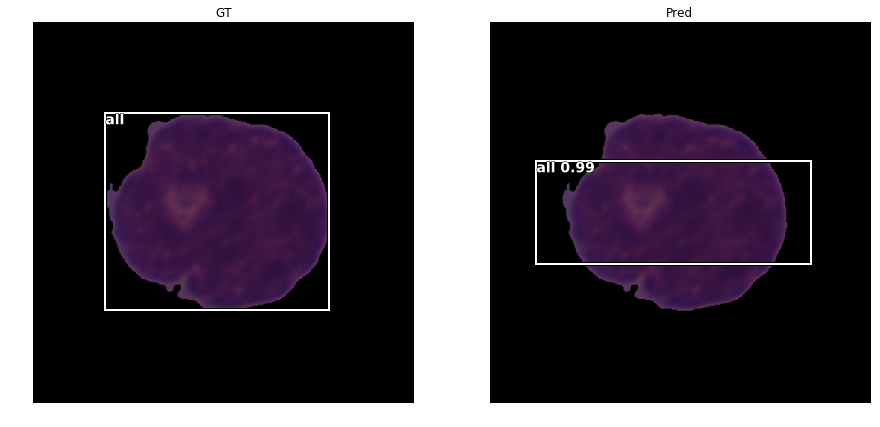

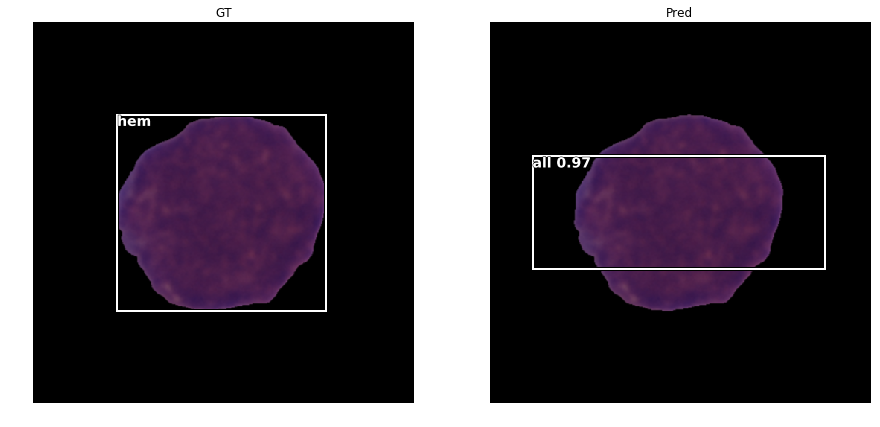

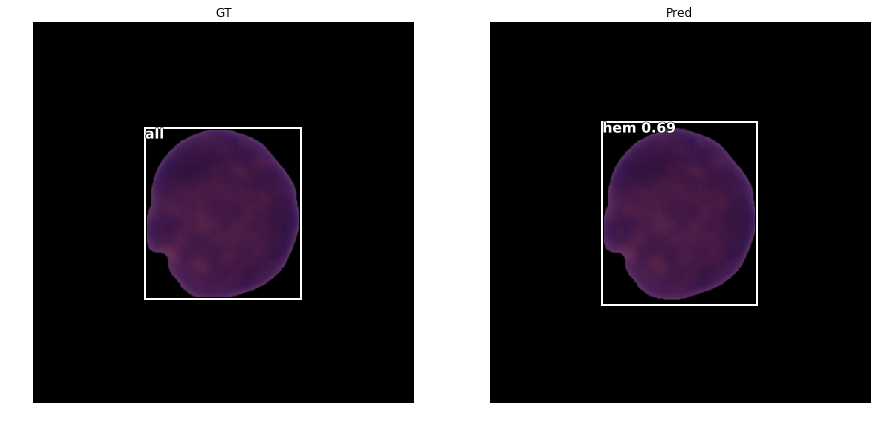

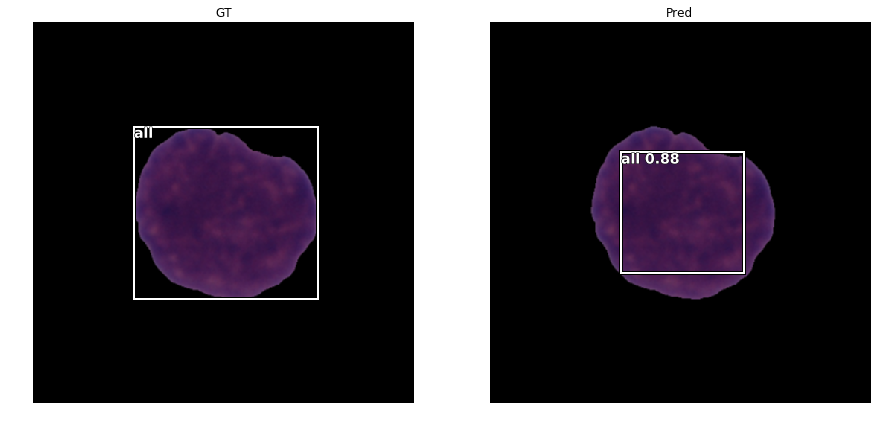

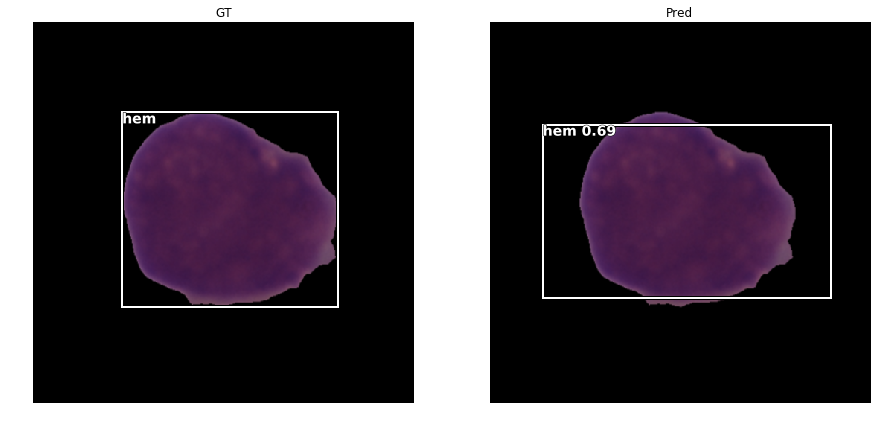

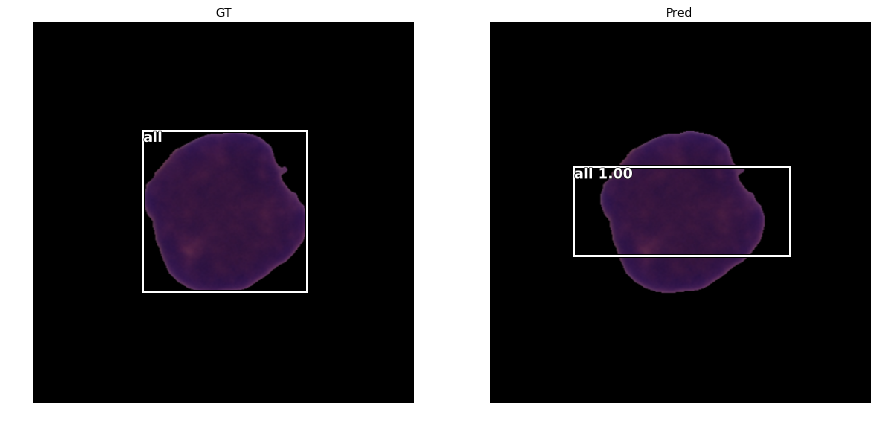

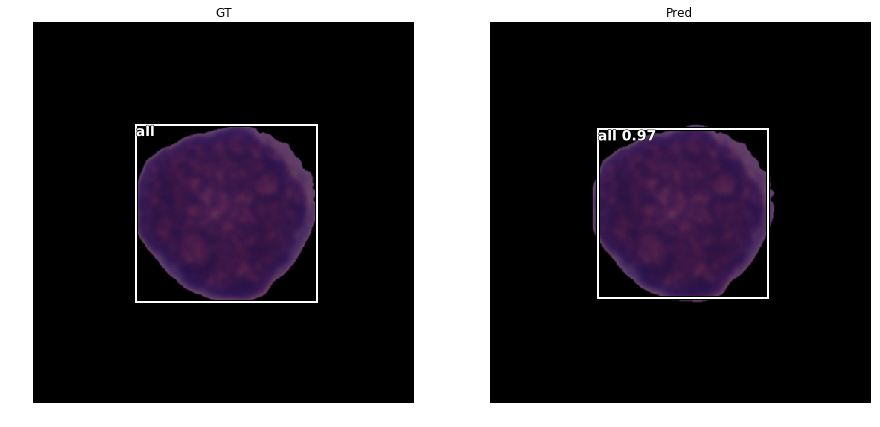

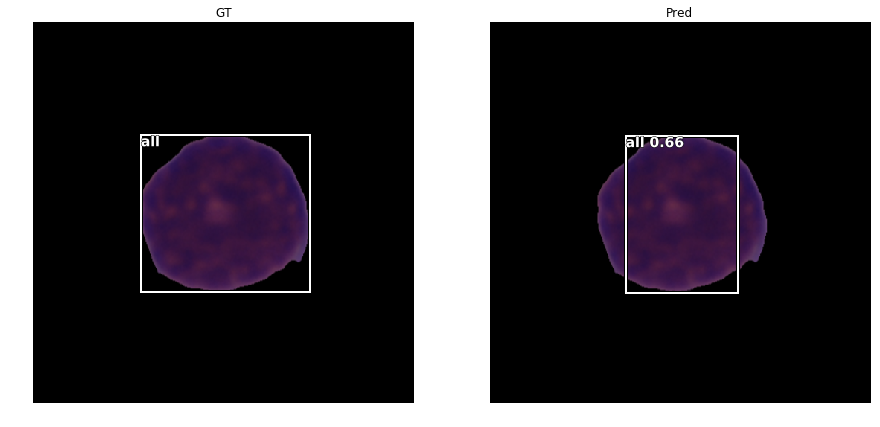

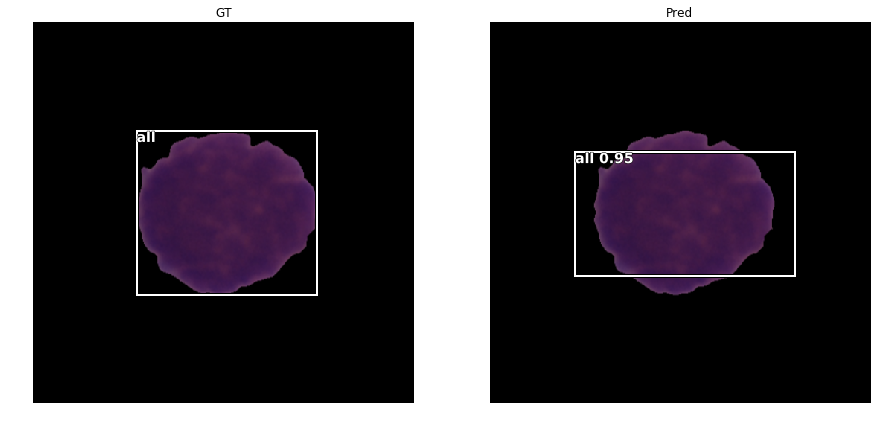

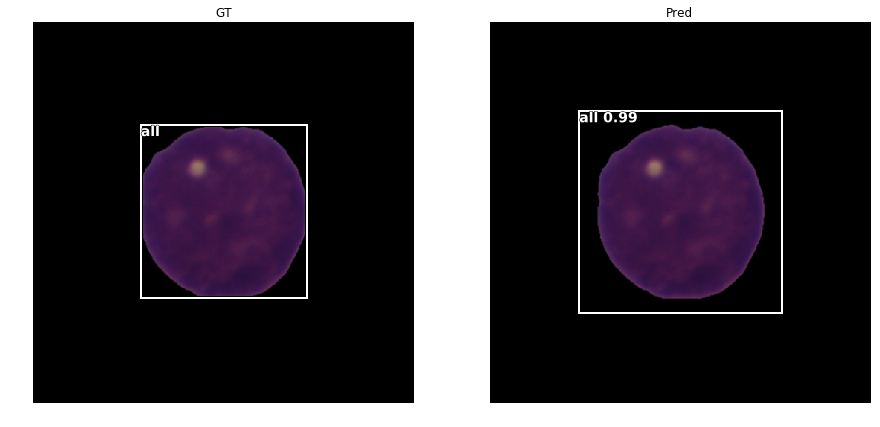

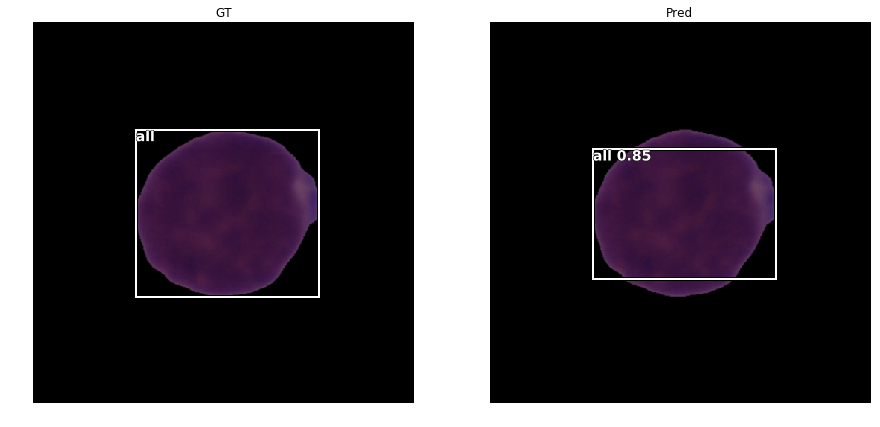

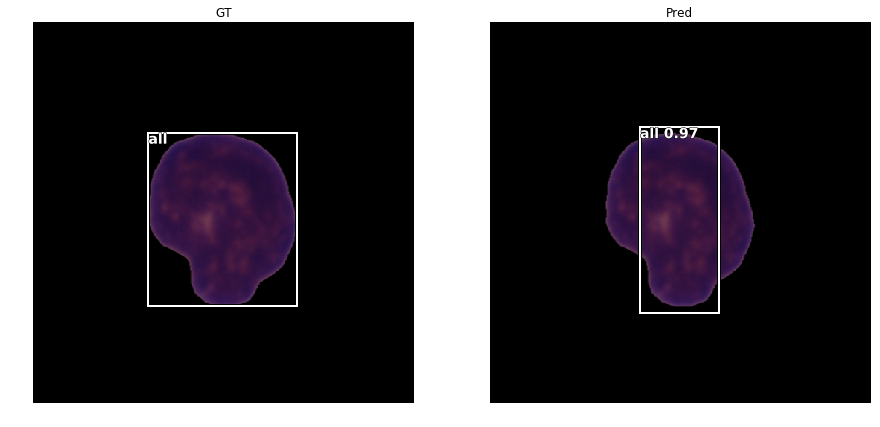

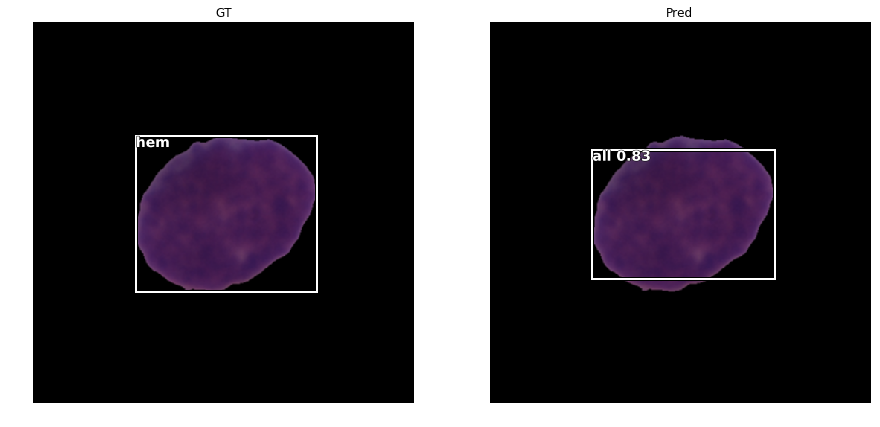

In [30]:
detect_thresh = 0.3
nms_thresh = 0.1
with torch.no_grad():
    for img_batch, target_batch in learn.data.valid_dl:
        prediction_batch = learn.model(img_batch)
        class_pred_batch, bbox_pred_batch = prediction_batch[:2]
        regression_pred_batch = prediction_batch[-1].view(-1) if len(prediction_batch) == 4 \
                else [None] * class_pred_batch.shape[0]
        bbox_gt_batch, class_gt_batch = target_batch

        for img, bbox_gt, class_gt, clas_pred, bbox_pred, reg_pred in \
                    list(zip(img_batch, bbox_gt_batch, class_gt_batch, class_pred_batch, bbox_pred_batch,
                             regression_pred_batch)):
            #img = Image(learn.data.denorm(img))
            img = Image(img)

            bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, detect_thresh)
            if bbox_pred is None:
                continue

            to_keep = nms(bbox_pred, scores, nms_thresh)
            bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

            t_sz = torch.Tensor([*img.size])[None].cpu()
            bbox_gt = bbox_gt[np.nonzero(class_gt)].squeeze(dim=1).cpu()
            class_gt = class_gt[class_gt > 0] - 1
            # change gt from x,y,x2,y2 -> x,y,w,h
            bbox_gt[:, 2:] = bbox_gt[:, 2:] - bbox_gt[:, :2]

            bbox_gt = to_np(rescale_boxes(bbox_gt, t_sz))
            bbox_pred = to_np(rescale_boxes(bbox_pred, t_sz))
            # change from center to top left
            bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2

            show_results(img, bbox_pred, preds, scores, data.train_ds.y.classes[1:]
                             , bbox_gt, class_gt, (15, 15), titleA="GT", titleB="Pred")
        break